# Loan Approval Classification — Notebook

Ce notebook effectue une Analyse Exploratoire des Données (Exploratory Data Analysis, EDA), le prétraitement, la sélection des features et propose différents modèles de classification des données.

## About Dataset
### 1. Data Source

This dataset is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

### 2. Metadata

Le dataset contient **45 000 observations** et **14 variables**.

#### Variables numériques (9)

| Variable | Description | Type |
|----------|-------------|------|
| `person_age` | Âge de la personne | Float |
| `person_income` | Revenu annuel | Float |
| `person_emp_exp` | Années d'expérience professionnelle | Integer |
| `loan_amnt` | Montant du prêt demandé | Float |
| `loan_int_rate` | Taux d'intérêt du prêt (%) | Float |
| `loan_percent_income` | Montant du prêt en % du revenu annuel | Float |
| `cb_person_cred_hist_length` | Durée de l'historique de crédit (années) | Float |
| `credit_score` | Score de crédit de la personne | Integer |
| **`loan_status`** *(target)* | **Statut d'approbation : 1 = approuvé, 0 = rejeté** | **Integer (binaire)** |

#### Variables catégorielles (5)

| Variable | Description | Modalités typiques |
|----------|-------------|-------------------|
| `person_gender` | Genre de la personne | Male, Female |
| `person_education` | Niveau d'éducation | High School, Bachelor, Master, Doctorate |
| `person_home_ownership` | Statut de propriété immobilière | Rent, Own, Mortgage, Other |
| `loan_intent` | Objectif du prêt | Education, Medical, Personal, Home Improvement, Debt Consolidation, Venture |
| `previous_loan_defaults_on_file` | Présence de défauts de paiement antérieurs | Yes, No |

### 3. Data Usage

The dataset can be used for multiple purposes:

- Exploratory Data Analysis (EDA): Analyze key features, distribution patterns, and relationships to understand credit risk factors.
- Classification: Build predictive models to classify the loan_status variable (approved/not approved) for potential applicants.
- Regression: Develop regression models to predict the credit_score variable based on individual and loan-related attributes.

Mind the data issue from the original data, such as the instance > 100-year-old as age.

This dataset provides a rich basis for understanding financial risk factors and simulating predictive modeling processes for loan approval and credit scoring.

## Points à améliorer

### Cosmétique

- Recherche de corrélation dans les données (ou pas du tout)
- Ajout des courbes recall/précision


### Tuner les modèles
- Faire varier les hyperparamètres des modèles et étudier leur impact sur les F1 score et le reste
- Faire un EnsembleModele pour déterminer si l'utilisation d'un modèle comprenant plusieurs sous modèles est plus performant


### Réaliser un réseau de neuronne (si on a le temps, il ne reste que 2 semaines avant la soumission du projet)



## Timeline des choses faites

- Vacances Toussaint : choix des données, création du fichier main (Félix), étude des données et premier modèle (régression linéaire) (Félix), ajout du Random Forest et XGBoost (Amaury), définition des métrics et de l'objectif.

- 7 Novembre : cosmétique et corrélation par Amaury

## Contexte et objectifs

### Contexte

Ce notebook a pour but d'explorer un jeu de données de demandes de prêt, de préparer les données et d'entraîner des modèles de classification (Logistic Regression) pour prédire si un prêt est accordé (`loan_status`).

Étapes réalisées dans ce document :
- Chargement et vérification rapide des données
- Analyse exploratoire (EDA) des variables
- Rééquilibrage de la target (undersampling des classes majoritaires)
- Prétraitement (imputation, standardisation, encodage) via une pipeline
- Sélection simple de features (corrélation)
- Entraînement de pipeline avec GridSearchCV pour les différents modèles
- Évaluation et sauvegarde du modèle

### Objectifs

Les modèles de classification peuvent être évalués suivant plusieurs métriques. Les plus connues d'entre elles sont la précision et le rappel (precision and recall). Le F1-score est une combinaison des deux tel que :

$$F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}$$


$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Où :
- **Precision** = $\frac{TP}{TP + FP}$ (proportion de prédictions positives correctes)
- **Recall** = $\frac{TP}{TP + FN}$ (proportion de vrais positifs détectés)
- TP = True Positives, FP = False Positives, FN = False Negatives

Le F1-score est la moyenne harmonique de la précision et du rappel, et atteint sa meilleure valeur à 1 (perfection) et sa pire à 0.


##### Pourquoi utilise-t-on le F1 score dans notre cas ?

Pour la banque, le plus important est une garantie de remboursement du crédit accordé. Il faut donc un être strict sur l'accord de celui-ci. On doit donc avoir un recall élevé.

En revanche, d'un point de vue morale, pour des questions d'attractivité de clientelle, la banque se doit aussi d'accorder des prêts.

On doit donc avoir un équilibre entre le recall et la précision : les deux sont importants et doivent afficher des scores élevés.


#### Objectif de F1 score

Qualitativement, on peut considérer notre modèle comme intéressant si le F1 est supérieur à 0.90, score pour lequel les recall et precision sont tous les deux hauts, garantissant à la fois une sécurité d'emprunt et une facilité d'acès à celui-ci.

$$F1 > 0.90$$

### Dépendances et kernel

Les bibliothèques importées nécessaires pour l'EDA, le prétraitement et l'entraînement.

- pandas / numpy : manipulation de données
- matplotlib : visualisations simples
- scikit-learn : pipelines, prétraitement, modèles, validation croisée
- joblib : gestion des sauvegardes locales du modèle

Les bibliothèques sont téléchargées en cas d'échec d'importation.

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pour avoir les graphiques directement dans le notebook
%matplotlib inline

# Configuration optionnelle pour Kaggle (si nécessaire)
# Décommentez et remplissez si vous avez besoin de télécharger depuis Kaggle
# import kaggle
# os.environ['KAGGLE_USERNAME'] = 'your_username'
# os.environ['KAGGLE_KEY'] = 'your_api_key'

### Chargement des données

Cette cellule charge le fichier CSV. Vérifiez le chemin `DATA_PATH`. Après le chargement, on affiche la dimension globale (`df.shape`) et un aperçu (`df.head()`). Si le fichier n'est pas trouvé, la cellule lève une erreur pour vous alerter.

In [4]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    import gdown
    # ID du fichier Google Drive (extrait du lien)
    file_id = '1aSRxZA8X0eRZAYoKwxuLLL98pBkmwc0Q'
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Télécharger le fichier
    gdown.download(url, DATA_PATH, quiet=False)
    print("✅ Téléchargement réussi depuis Google Drive!")
       
    
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

Répertoire actuel : c:\Users\felix\OneDrive\Documents\3A\AAA\projet-Apprentissage-Automatique
Dimensions: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Inspection rapide des types et des valeurs manquantes

Cette cellule :
- affiche le résumé `df.info()` (types et valeurs non-null)
- compte les valeurs manquantes par colonne
- convertit `person_age` en entier si présent (attention : perte d'infos si valeurs non-integers)
- construit deux listes `cat_cols` et `num_cols` basées sur le dtype (utile pour l'EDA et la construction de transformers)

In [5]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    # On cast en int pour éviter des types float si tout est entier en pratique
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

None


Valeurs manquantes par colonne:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Colonnes catégorielles: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Colonnes numériques: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


### EDA : distributions et visualisations simples

But : comprendre la distribution des catégories, repérer des déséquilibres évidents, et observer la distribution des variables numériques (skewness, valeurs extrêmes).

- Pour les colonnes catégorielles, on trace un diagramme en barres des effectifs.
- Pour les colonnes numériques, on affiche des histogrammes.
- On affiche aussi la distribution de la target `loan_status` (pie chart) pour voir le déséquilibre initial.


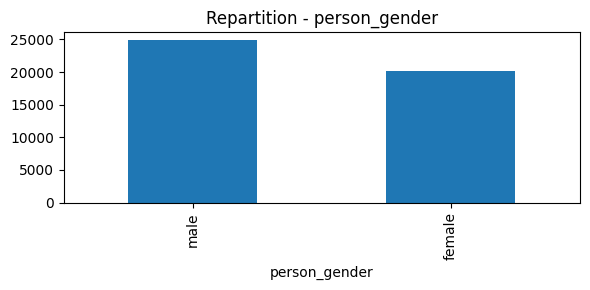

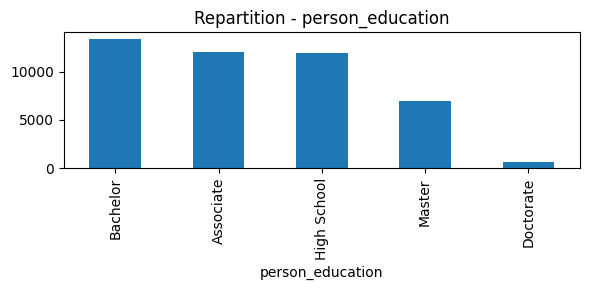

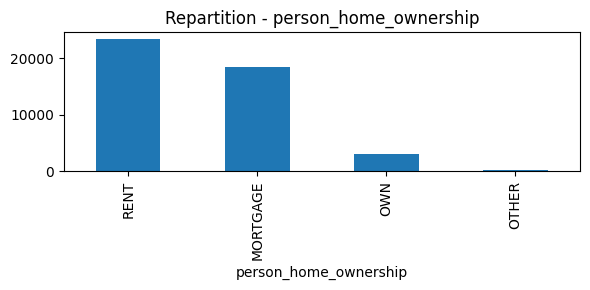

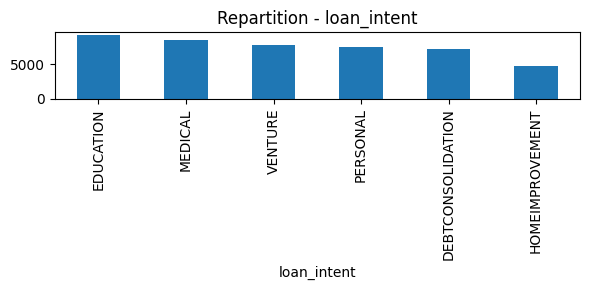

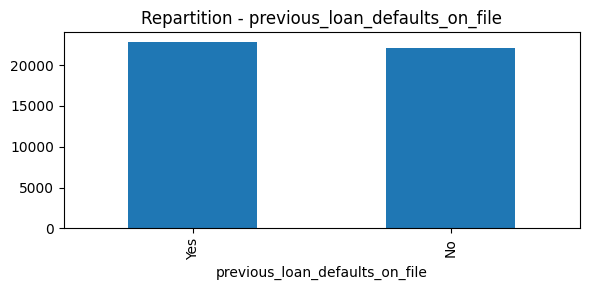

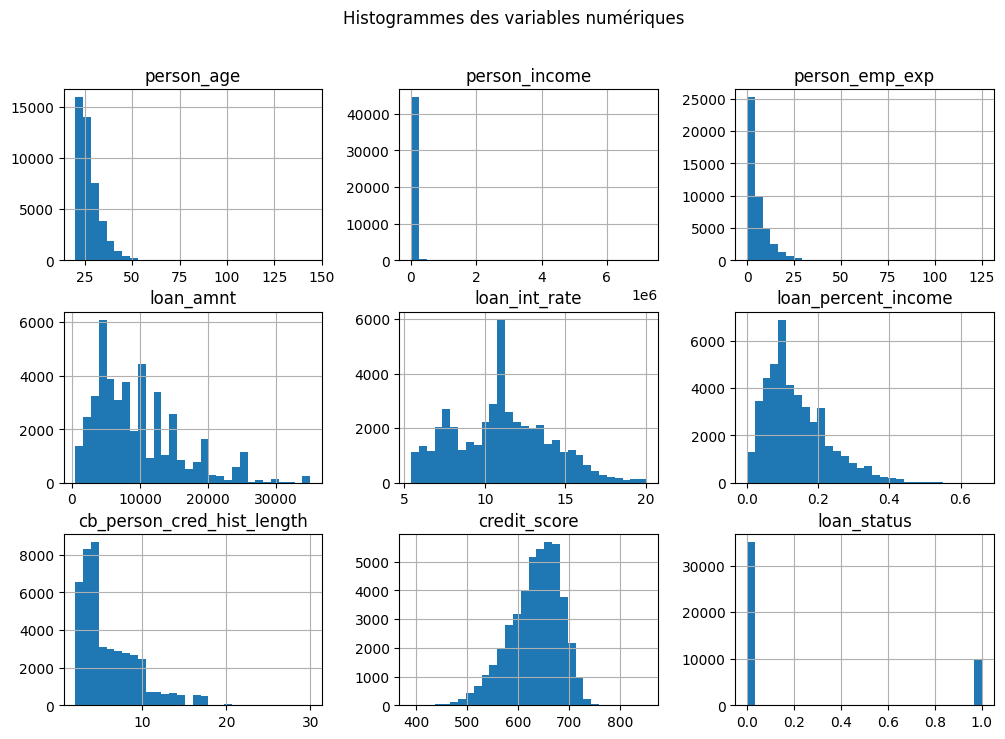

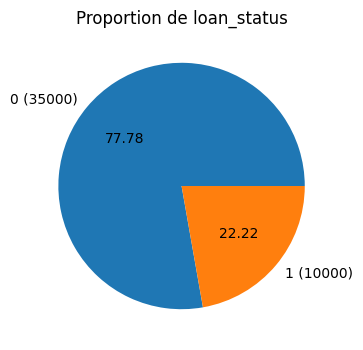

In [6]:
# EDA simple: distributions des catégorielles et des numériques
for c in cat_cols:
    plt.figure(figsize=(6,3))
    # value_counts() montre les modalités et leurs effectifs
    df[c].value_counts().plot(kind='bar', title=f'Repartition - {c}')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

if num_cols:
    # histogrammes groupés pour repérer la forme des distributions
    df[num_cols].hist(bins=30, figsize=(12,8))
    plt.suptitle('Histogrammes des variables numériques')
    plt.show()

# Distribution de la target
if 'loan_status' in df.columns:
    counts = df['loan_status'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(counts, labels=[str(i) + ' (' + str(n) + ')' for i,n in zip(counts.index, counts)], autopct='%.2f')
    plt.title('Proportion de loan_status')
    plt.show()


## Études des corrélations potentiels

Nous pouvons supposer que certains groupes sociaux sont plus enclins à avoir bénéficier d'accord pour un emprunt.

Par exemple, certains facteurs comme l'éducation, le montant emprunté, le montant par rapport au salaire, le score crédit de la personne peuvent directement avoir une influence sur l'emprunt.

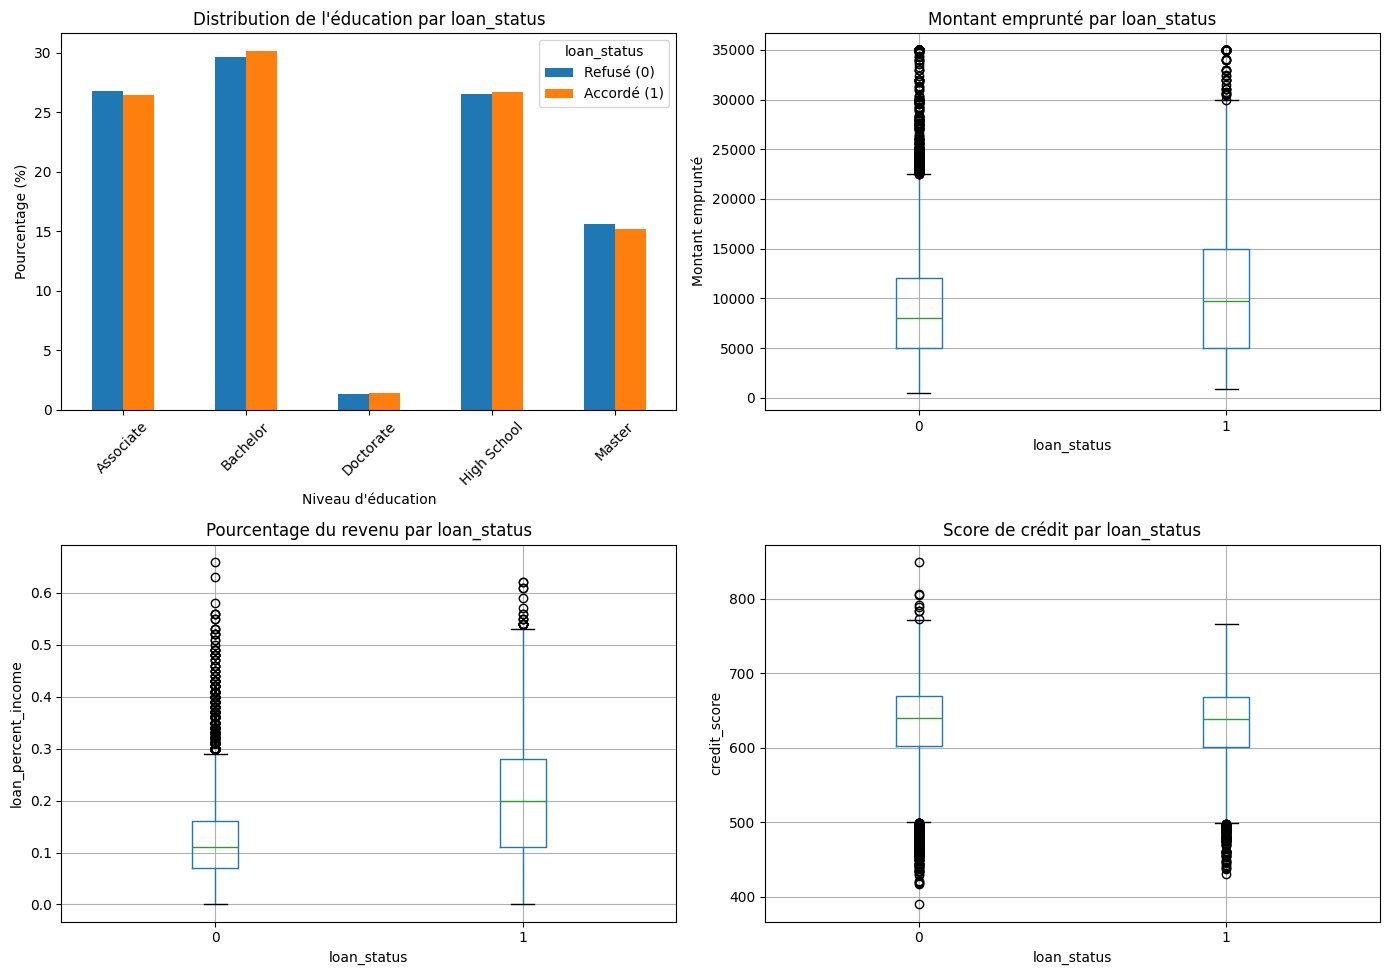

In [7]:
# Analyse de la corrélation entre loan_status et différentes variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Éducation vs loan_status
ax1 = axes[0, 0]
education_status = pd.crosstab(df['loan_status'], df['person_education'], normalize='index') * 100
education_status.T.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution de l\'éducation par loan_status')
ax1.set_xlabel('Niveau d\'éducation')
ax1.set_ylabel('Pourcentage (%)')
ax1.legend(title='loan_status', labels=['Refusé (0)', 'Accordé (1)'])
ax1.tick_params(axis='x', rotation=45)

# 2. Montant emprunté vs loan_status
ax2 = axes[0, 1]
df.boxplot(column='loan_amnt', by='loan_status', ax=ax2)
ax2.set_title('Montant emprunté par loan_status')
ax2.set_xlabel('loan_status')
ax2.set_ylabel('Montant emprunté')
ax2.get_figure().suptitle('')

# 3. Pourcentage du revenu vs loan_status
ax3 = axes[1, 0]
df.boxplot(column='loan_percent_income', by='loan_status', ax=ax3)
ax3.set_title('Pourcentage du revenu par loan_status')
ax3.set_xlabel('loan_status')
ax3.set_ylabel('loan_percent_income')
ax3.get_figure().suptitle('')

# 4. Score de crédit vs loan_status
ax4 = axes[1, 1]
df.boxplot(column='credit_score', by='loan_status', ax=ax4)
ax4.set_title('Score de crédit par loan_status')
ax4.set_xlabel('loan_status')
ax4.set_ylabel('credit_score')
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

Pas vraiment de corrélation...

## Méthodes d'analyse de corrélation

Pour comprendre les relations entre les variables et la target `loan_status`, nous utilisons **trois approches complémentaires** permettant d'analyser respectivement les variables numériques et catégorielles.

---

### 1. Corrélation de Pearson (Variables numériques)

#### Définition

Le coefficient de corrélation de Pearson mesure l'intensité et la direction de la relation **linéaire** entre deux variables quantitatives.

#### Formule mathématique

$$r_{X,Y} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

**Où :**
- $r_{X,Y}$ : coefficient de corrélation de Pearson entre les variables X et Y
- $n$ : nombre d'observations
- $x_i$ : valeur de la variable X pour l'observation i
- $y_i$ : valeur de la variable Y pour l'observation i
- $\bar{x}$ : moyenne arithmétique de la variable X, calculée comme $\bar{x} = \frac{1}{n}\sum_{i=1}^{n}x_i$
- $\bar{y}$ : moyenne arithmétique de la variable Y, calculée comme $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$

#### Interprétation des valeurs

| Valeur de r | Interprétation |
|-------------|----------------|
| r = 1 | Corrélation positive parfaite (relation linéaire croissante) |
| 0.7 ≤ r < 1 | Corrélation positive forte |
| 0.3 ≤ r < 0.7 | Corrélation positive modérée |
| 0 < r < 0.3 | Corrélation positive faible |
| r = 0 | Absence de corrélation linéaire |
| -0.3 < r < 0 | Corrélation négative faible |
| -0.7 < r ≤ -0.3 | Corrélation négative modérée |
| -1 < r ≤ -0.7 | Corrélation négative forte |
| r = -1 | Corrélation négative parfaite (relation linéaire décroissante) |

#### Hypothèses et limites

**Hypothèses :**
- Les deux variables doivent être quantitatives (continues ou discrètes)
- La relation entre les variables doit être linéaire
- Les données ne doivent pas présenter d'outliers extrêmes

**Limites importantes :**
- Ne détecte que les relations **linéaires** (relations non-linéaires ignorées)
- Sensible aux valeurs aberrantes qui peuvent fausser le coefficient
- Un coefficient de corrélation ne permet **pas** de conclure sur la causalité (corrélation ≠ causalité)
- Une corrélation nulle n'implique pas l'absence de relation (peut exister une relation non-linéaire)

#### Application dans notre étude

- **Heatmap** : visualisation globale des corrélations entre toutes les variables numériques du dataset
- **Corrélation avec loan_status** : identification des variables numériques les plus prédictives de l'approbation du prêt

---

### 2. Test du Chi² (χ²) - Variables catégorielles

#### Définition

Le test du Chi² d'indépendance est un test statistique permettant de déterminer si deux variables catégorielles sont indépendantes ou s'il existe une association significative entre elles.

#### Hypothèses statistiques

- **H₀** (hypothèse nulle) : les deux variables sont **indépendantes** (aucune association)
- **H₁** (hypothèse alternative) : les deux variables sont **dépendantes** (association significative)

#### Statistique de test

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Où :**
- $\chi^2$ : statistique du Chi² calculée
- $r$ : nombre de lignes du tableau de contingence (nombre de modalités de la première variable)
- $c$ : nombre de colonnes du tableau de contingence (nombre de modalités de la seconde variable)
- $O_{ij}$ : fréquence **observée** dans la cellule (i, j), c'est-à-dire le nombre réel d'observations
- $E_{ij}$ : fréquence **attendue** dans la cellule (i, j) sous l'hypothèse d'indépendance

#### Calcul des fréquences attendues

Sous l'hypothèse d'indépendance (H₀), la fréquence attendue pour chaque cellule est calculée comme :

$$E_{ij} = \frac{(\text{total ligne } i) \times (\text{total colonne } j)}{\text{total général}}$$

Plus formellement :

$$E_{ij} = \frac{n_{i\cdot} \times n_{\cdot j}}{n}$$

**Où :**
- $n_{i\cdot}$ : somme marginale de la ligne i (total de la ligne)
- $n_{\cdot j}$ : somme marginale de la colonne j (total de la colonne)
- $n$ : effectif total (somme de toutes les observations)

#### Interprétation de la p-value

La p-value représente la probabilité d'observer une statistique χ² aussi extrême (ou plus) que celle calculée, si H₀ est vraie.

| p-value | Décision | Interprétation |
|---------|----------|----------------|
| p < 0.05 | Rejet de H₀ | Les variables sont significativement dépendantes (association statistiquement significative au seuil α = 5%) |
| p ≥ 0.05 | Non-rejet de H₀ | Pas de preuve suffisante d'une dépendance (les variables peuvent être considérées comme indépendantes) |

Note : Le seuil α = 0.05 est conventionnel mais peut être ajusté selon le contexte (0.01 ou 0.10).

#### Conditions d'application

- Les observations doivent être indépendantes
- Les effectifs attendus doivent être suffisamment grands : $E_{ij} \geq 5$ pour au moins 80% des cellules
- Si cette condition n'est pas respectée, utiliser le test exact de Fisher

#### Limites

- Le test du Chi² indique uniquement la **significativité** de l'association (existence d'un lien)
- Il ne mesure **pas l'intensité** de cette association
- Sensible à la taille de l'échantillon : avec un grand n, des associations faibles peuvent devenir significatives

---

### 3. Cramér's V - Intensité de l'association

#### Définition

Le V de Cramér est une mesure normalisée de l'intensité de l'association entre deux variables catégorielles. Il complète le test du Chi² en quantifiant la **force** de l'association détectée.

#### Formule de calcul

$$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

**Où :**
- $V$ : coefficient V de Cramér (compris entre 0 et 1)
- $\chi^2$ : statistique du Chi² calculée précédemment
- $n$ : nombre total d'observations
- $r$ : nombre de lignes du tableau de contingence
- $c$ : nombre de colonnes du tableau de contingence
- $\min(r-1, c-1)$ : le minimum entre (r-1) et (c-1), utilisé pour la normalisation

#### Interprétation des valeurs

| Valeur de V | Intensité de l'association |
|-------------|---------------------------|
| V = 0 | Aucune association (indépendance parfaite) |
| 0 < V < 0.1 | Association négligeable |
| 0.1 ≤ V < 0.3 | Association faible |
| 0.3 ≤ V < 0.5 | Association modérée |
| V ≥ 0.5 | Association forte |
| V = 1 | Association parfaite (dépendance complète) |

#### Avantages

- **Normalisation** : valeur comprise entre 0 et 1, permettant la comparaison entre différentes paires de variables
- **Interprétation intuitive** : plus V est élevé, plus l'association est forte
- **Complément du Chi²** : combine significativité (Chi²) et intensité (V de Cramér)

#### Différence avec le Chi²

| Critère | Chi² (p-value) | V de Cramér |
|---------|----------------|-------------|
| Nature | Test d'hypothèse | Mesure d'association |
| Réponse | Existe-t-il une association ? (oui/non) | Quelle est l'intensité de l'association ? |
| Interprétation | Significativité statistique | Force de la relation |
| Sensibilité à n | Très sensible (augmente avec n) | Peu sensible (normalisé) |

---

### Synthèse méthodologique

| Méthode | Type de variables | Ce qu'elle mesure | Valeur critique | Interprétation |
|---------|-------------------|-------------------|-----------------|----------------|
| **Pearson (r)** | Numérique ↔ Numérique | Force et direction de la relation linéaire | \|r\| > 0.5 | Forte corrélation linéaire |
| **Chi² (p-value)** | Catégorielle ↔ Catégorielle | Significativité statistique de la dépendance | p < 0.05 | Association statistiquement significative |
| **Cramér's V** | Catégorielle ↔ Catégorielle | Intensité de l'association | V > 0.3 | Association modérée à forte |

---

### Application au contexte bancaire

Dans notre étude de prédiction d'approbation de prêt, ces méthodes permettent d'identifier :

**Variables numériques (Pearson) :**
- Corrélation entre `credit_score` et `loan_status`
- Relation entre `loan_amnt` et `person_income`
- Impact de `loan_percent_income` sur l'approbation

**Variables catégorielles (Chi² et Cramér's V) :**
- Association entre `person_education` et `loan_status`
- Lien entre `loan_intent` et l'approbation du prêt
- Influence du `person_home_ownership` sur la décision

Cette analyse multidimensionnelle permet de sélectionner les features les plus pertinentes pour la modélisation prédictive.

---

### Références bibliographiques

- Pearson, K. (1895). "Notes on regression and inheritance in the case of two parents". *Proceedings of the Royal Society of London*, 58, 240-242.
- Pearson, K. (1900). "On the criterion that a given system of deviations from the probable in the case of a correlated system of variables is such that it can be reasonably supposed to have arisen from random sampling". *Philosophical Magazine*, 50(302), 157-175.
- Cramér, H. (1946). *Mathematical Methods of Statistics*. Princeton University Press.
- Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences* (2nd ed.). Routledge.

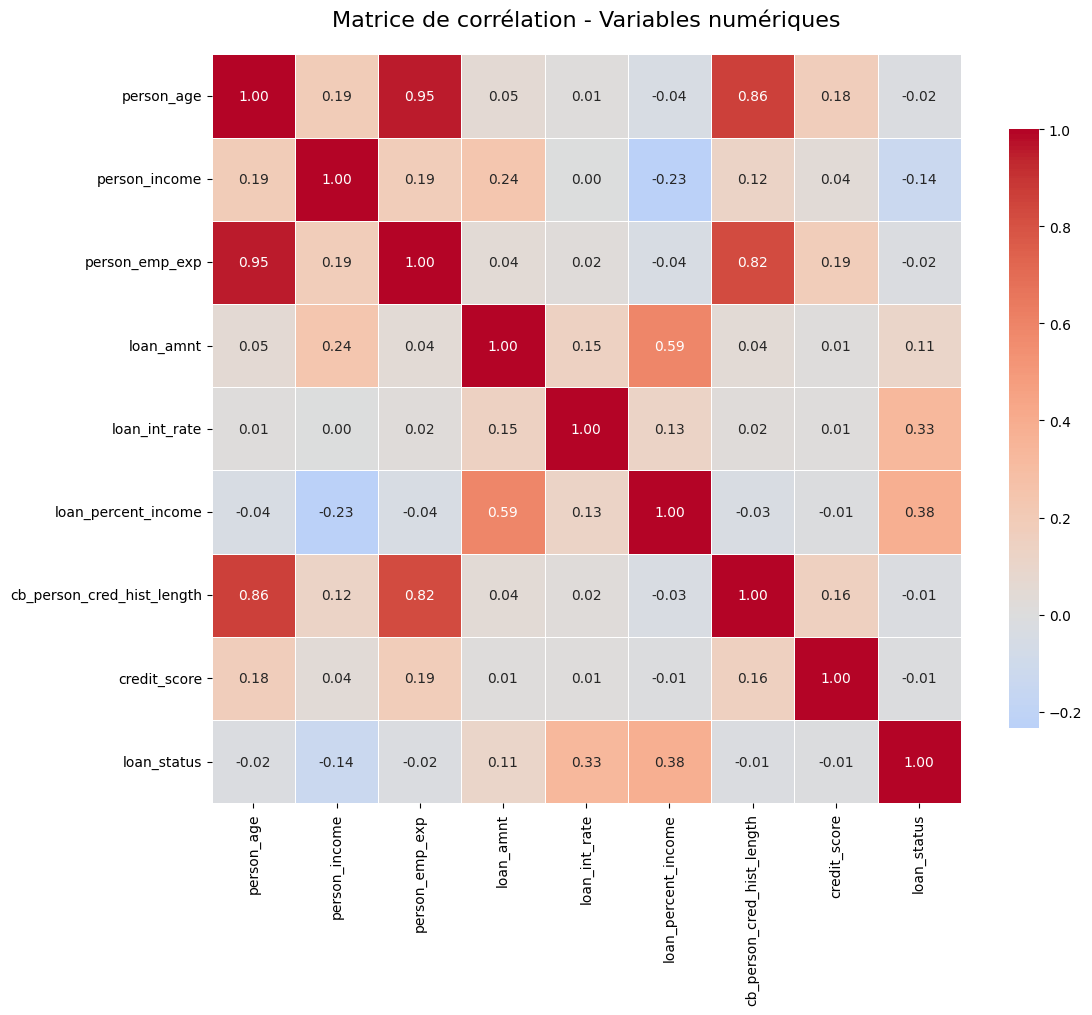


🔍 Paires de variables fortement corrélées (|r| > 0.5):
  • person_age ↔ person_emp_exp: 0.954
  • person_age ↔ cb_person_cred_hist_length: 0.862
  • person_emp_exp ↔ cb_person_cred_hist_length: 0.824
  • loan_amnt ↔ loan_percent_income: 0.593


In [8]:
## Analyse approfondie des corrélations

### 1. Heatmap de corrélation (variables numériques)

import seaborn as sns

# Calculer la matrice de corrélation pour toutes les variables numériques
correlation_matrix = df[num_cols].corr()

# Créer la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,           # Afficher les valeurs
    fmt='.2f',            # Format des nombres (2 décimales)
    cmap='coolwarm',      # Palette de couleurs (bleu=négatif, rouge=positif)
    center=0,             # Centrer sur 0
    square=True,          # Cellules carrées
    linewidths=0.5,       # Lignes entre cellules
    cbar_kws={"shrink": 0.8}
)
plt.title('Matrice de corrélation - Variables numériques', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Identifier les corrélations fortes (hors diagonale)
print("\n🔍 Paires de variables fortement corrélées (|r| > 0.5):")
print("="*60)

# Extraire les corrélations fortes
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_corr.append((var1, var2, corr_value))

# Trier par valeur absolue décroissante
strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)

if strong_corr:
    for var1, var2, corr in strong_corr:
        print(f"  • {var1} ↔ {var2}: {corr:.3f}")
else:
    print("  Aucune corrélation forte détectée (toutes < 0.5)")

array([[<Axes: xlabel='person_age', ylabel='person_age'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_age'>],
       [<Axes: xlabel='person_age', ylabel='person_emp_exp'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_emp_exp'>]],
      dtype=object)

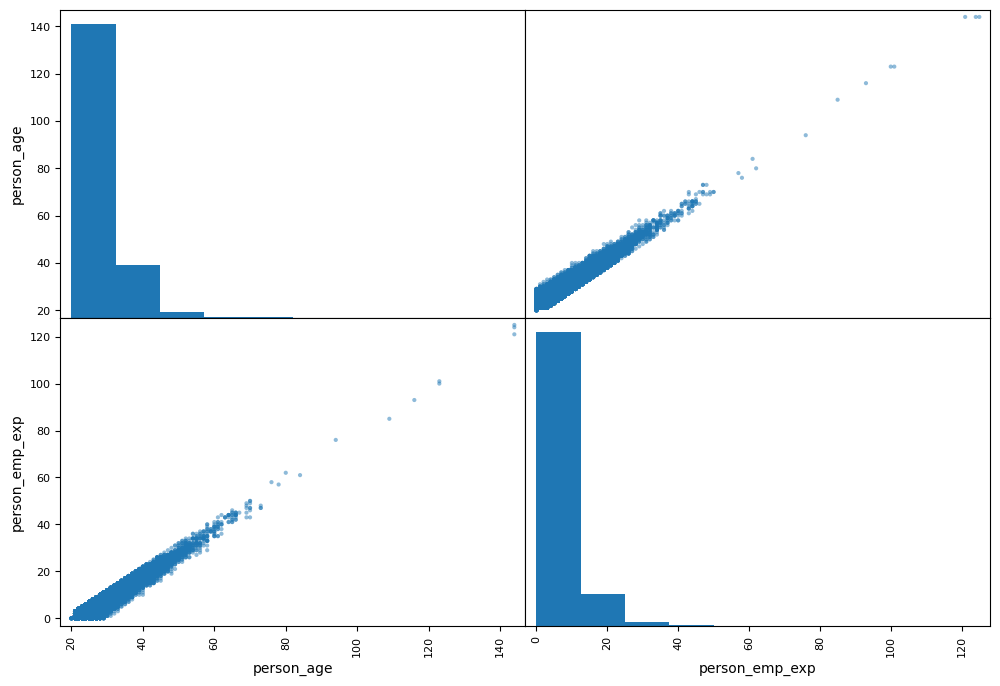

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["person_age", "person_emp_exp"]], figsize=(12,8))

C'est normal, il est logique que, plus une personne vieillisse, plus elle travaille. Il en est de même pour les deux autres corrélations croissante.


📊 Corrélation des variables numériques avec loan_status:
loan_status                   1.000000
loan_percent_income           0.384880
loan_int_rate                 0.332005
loan_amnt                     0.107714
credit_score                 -0.007647
cb_person_cred_hist_length   -0.014851
person_emp_exp               -0.020481
person_age                   -0.021476
person_income                -0.135808


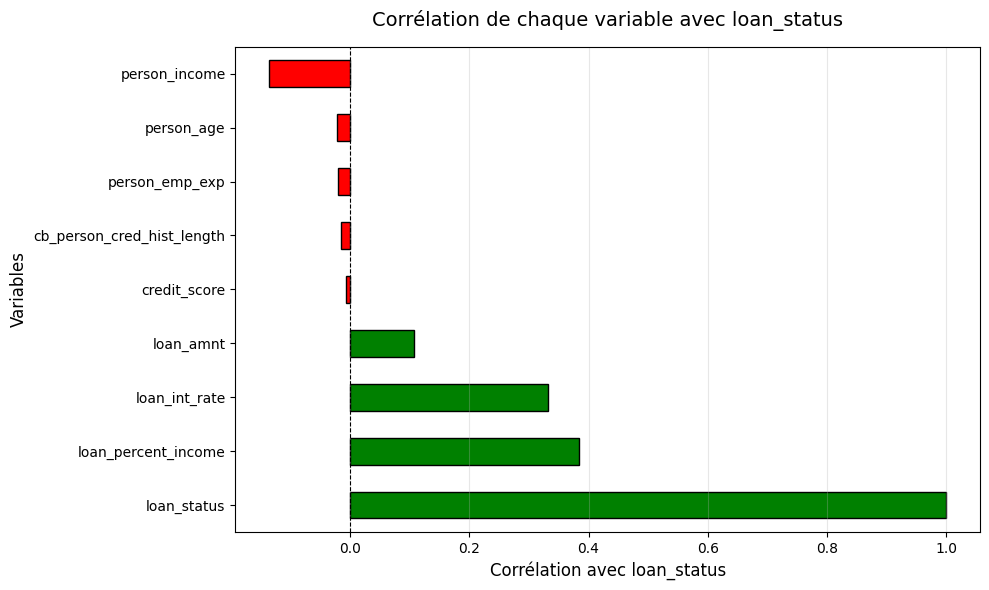


💡 Interprétation:

✅ Top 3 variables FAVORISANT l'approbation (corrélation positive):
  • loan_percent_income: 0.385
  • loan_int_rate: 0.332

❌ Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):
  • person_emp_exp: -0.020
  • person_age: -0.021
  • person_income: -0.136

📌 Variables avec corrélation significative (|r| > 0.1): 4


In [10]:
### 2. Corrélation avec loan_status uniquement

# Calculer la corrélation de toutes les variables numériques avec loan_status
correlations_with_target = df[num_cols].corrwith(df['loan_status']).sort_values(ascending=False)

# Afficher le tableau
print("\n📊 Corrélation des variables numériques avec loan_status:")
print("="*60)
print(correlations_with_target.to_string())

# Visualisation en barplot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_with_target.values]
correlations_with_target.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Corrélation avec loan_status', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Corrélation de chaque variable avec loan_status', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpréter les résultats
print("\n💡 Interprétation:")
print("="*60)
top_positive = correlations_with_target.head(3)
top_negative = correlations_with_target.tail(3)

print("\n✅ Top 3 variables FAVORISANT l'approbation (corrélation positive):")
for var, corr in top_positive.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")
        
print("\n❌ Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):")
for var, corr in top_negative.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")

# Seuil de significativité
significant_vars = correlations_with_target[abs(correlations_with_target) > 0.1]
print(f"\n📌 Variables avec corrélation significative (|r| > 0.1): {len(significant_vars)-1}")

ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS

1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_percent_income
Corrélation avec loan_status : 0.385
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count      mean       std  min   25%   50%   75%   max
loan_status                                                          
0            35000.0  0.121783  0.071339  0.0  0.07  0.11  0.16  0.66
1            10000.0  0.202521  0.106514  0.0  0.11  0.20  0.28  0.62

Test de Student (différence de moyennes) :
  • Statistique t : -88.458
  • p-value : 0.0000e+00
  • Conclusion : Différence SIGNIFICATIVE

────────────────────────────────────────────────────────────────────────────────
Variable : loan_percent_income
Corrélation avec loan_status : 0.385
─────────

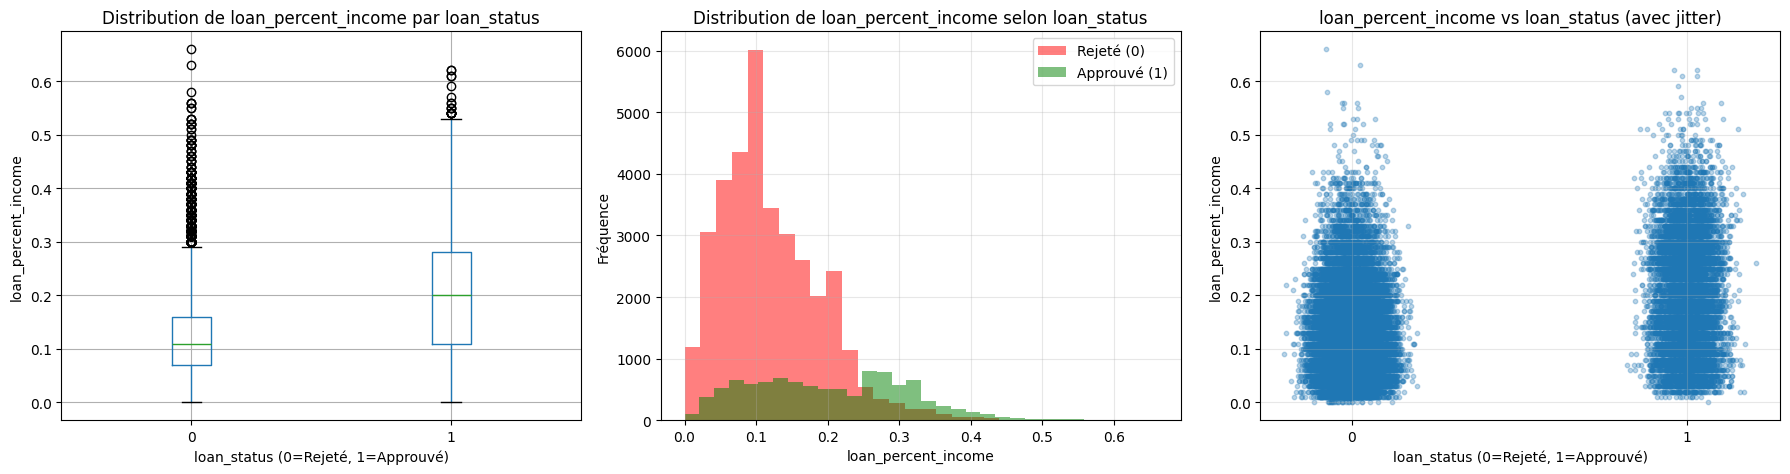


📊 INTERPRÉTATION :
  • Les prêts approuvés ont un ratio prêt/revenu PLUS ÉLEVÉ en moyenne
  • Cela peut sembler contre-intuitif, mais peut indiquer :
    - Les personnes approuvées empruntent des montants plus importants relativement à leur revenu
    - Les banques acceptent des ratios plus élevés pour certains profils (ex: revenus stables)
    - Possible biais dans les données synthétiques

────────────────────────────────────────────────────────────────────────────────
Variable : loan_int_rate
Corrélation avec loan_status : 0.332
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count       mean       std   min    25%    50%    75%   max
loan_status                                                               
0            35000.0  10.477981  2.731490  5.42   7.90  10.85  12.29  20.0
1            10000.0  12.856794  3.068512  5.42  10.99  12.98  15.23  20.0

Test de Student (différence de moy

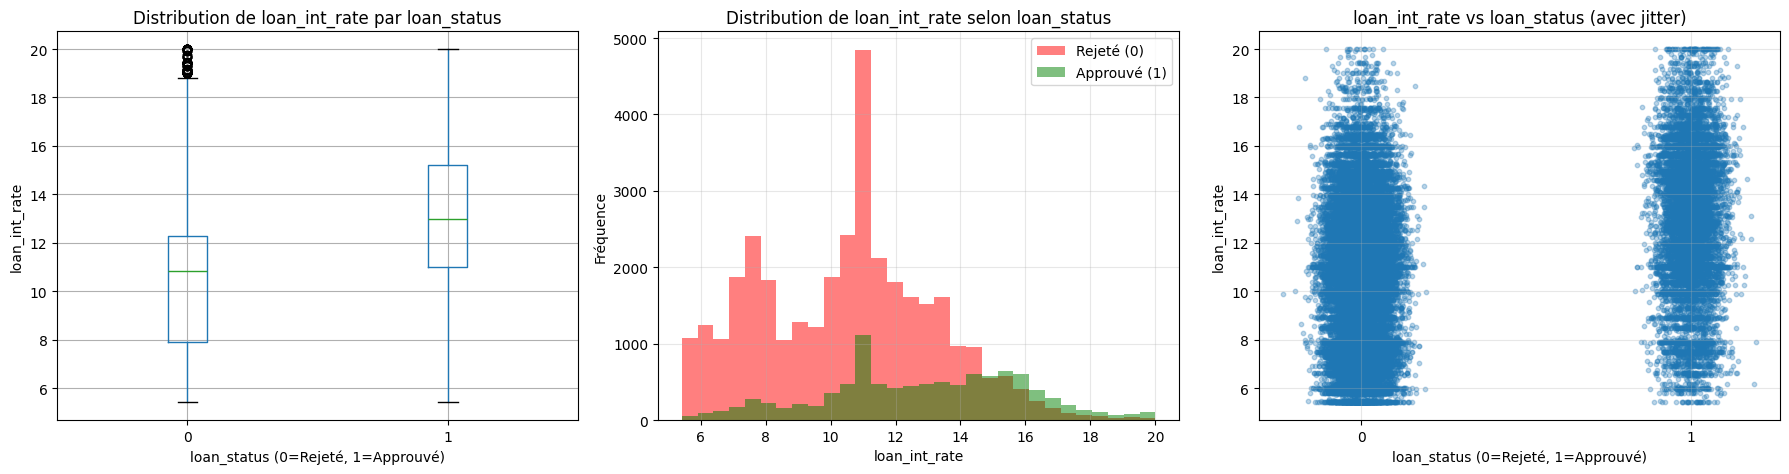


📊 INTERPRÉTATION :
  • Les prêts approuvés ont des TAUX D'INTÉRÊT PLUS ÉLEVÉS en moyenne
  • Interprétation possible :
    - Les banques compensent le risque par des taux plus élevés
    - Les profils à risque acceptent des taux plus élevés pour obtenir le prêt
    - Corrélation ne signifie pas causalité : d'autres facteurs peuvent intervenir


2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)

────────────────────────────────────────────────────────────────────────────────
Variable : person_income
Corrélation avec loan_status : -0.136
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count          mean           std     min       25%      50%  \
loan_status                                                                   
0            35000.0  86157.040743  87035.235344  9595.0  51476.50  72928.0   
1            10000.0  59886.096900  45338.315604  80

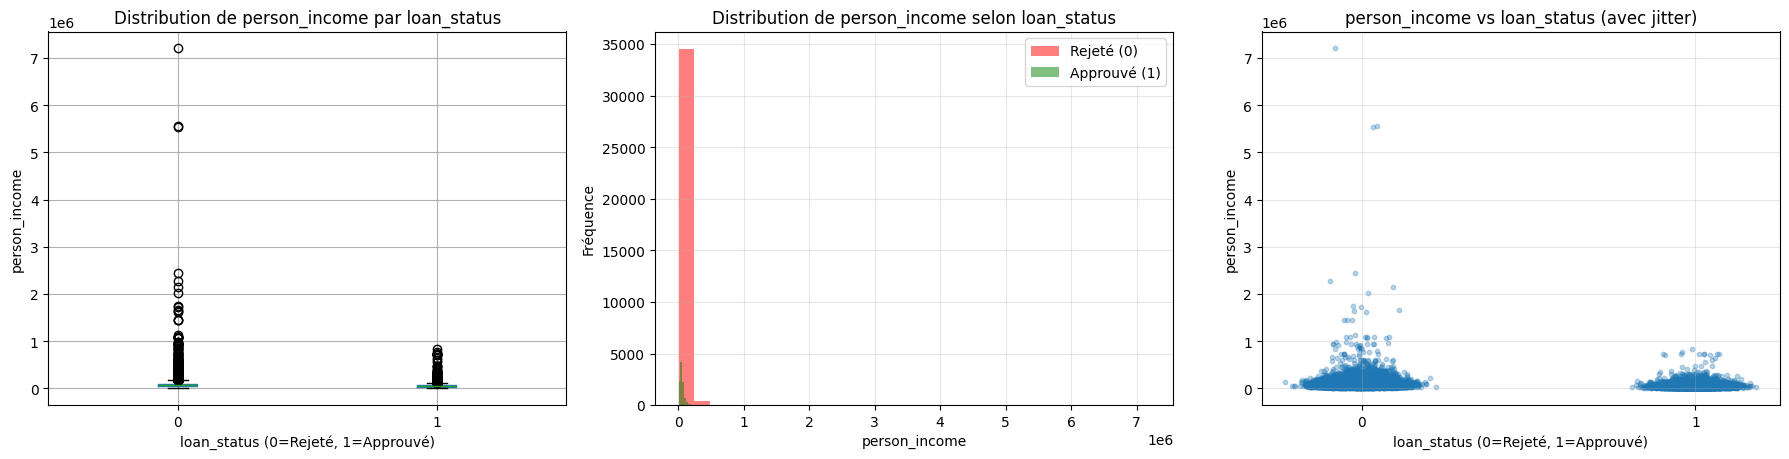


📊 INTERPRÉTATION :
  • Les prêts approuvés ont des REVENUS PLUS FAIBLES en moyenne
  • Cela peut sembler contre-intuitif, mais peut indiquer :
    - Les hauts revenus ont moins besoin d'emprunter
    - Les hauts revenus empruntent via d'autres canaux (banques privées)
    - Biais dans les données synthétiques

────────────────────────────────────────────────────────────────────────────────
Variable : credit_score
Corrélation avec loan_status : -0.008
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count        mean        std    min    25%    50%    75%    max
loan_status                                                                   
0            35000.0  632.814914  50.475294  390.0  602.0  640.0  670.0  850.0
1            10000.0  631.887200  50.293485  431.0  601.0  639.0  669.0  767.0

Test de Student (différence de moyennes) :
  • Statistique t : 1.622
  • p-value : 1.0476e-01
  • Con

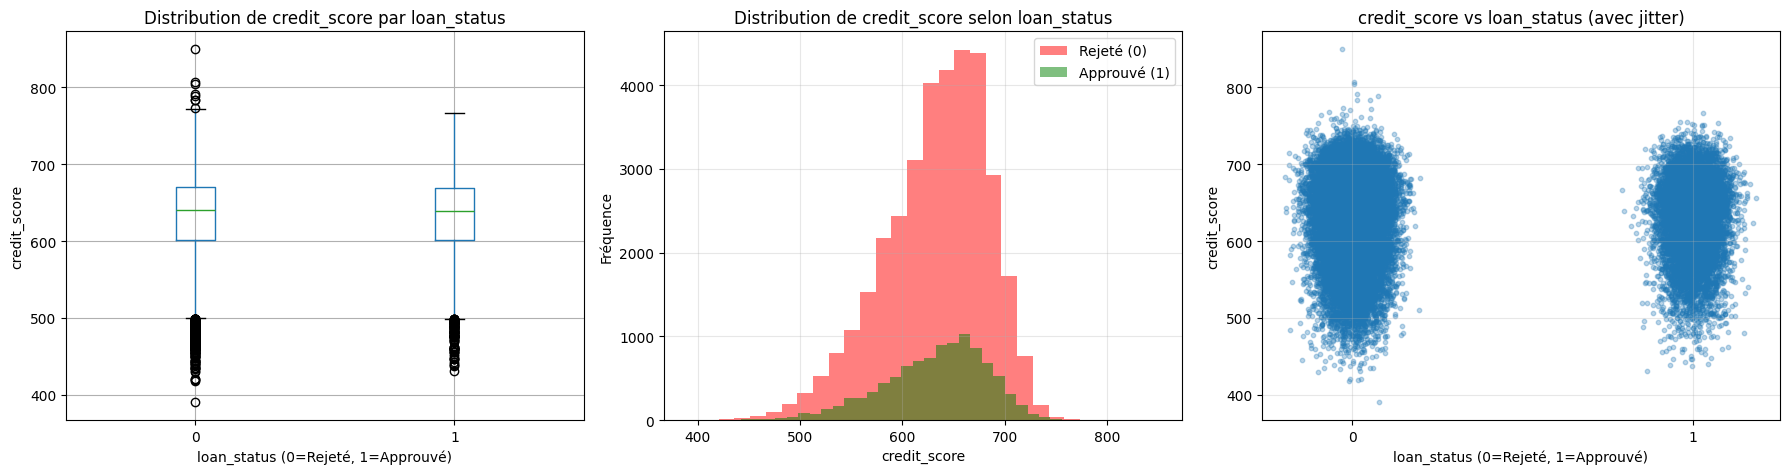


📊 INTERPRÉTATION :
  • Les prêts approuvés ont des SCORES DE CRÉDIT PLUS FAIBLES en moyenne
  • ⚠️ ATTENTION : cela est très contre-intuitif !
  • Possible explication :
    - Artefact des données synthétiques (SMOTENC)
    - À vérifier en production avec des données réelles

────────────────────────────────────────────────────────────────────────────────
Variable : person_age
Corrélation avec loan_status : -0.021
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count       mean       std   min   25%   50%   75%    max
loan_status                                                             
0            35000.0  27.833571  6.073367  20.0  24.0  26.0  30.0  144.0
1            10000.0  27.521300  5.939063  20.0  23.0  26.0  30.0   70.0

Test de Student (différence de moyennes) :
  • Statistique t : 4.557
  • p-value : 5.2098e-06
  • Conclusion : Différence SIGNIFICATIVE


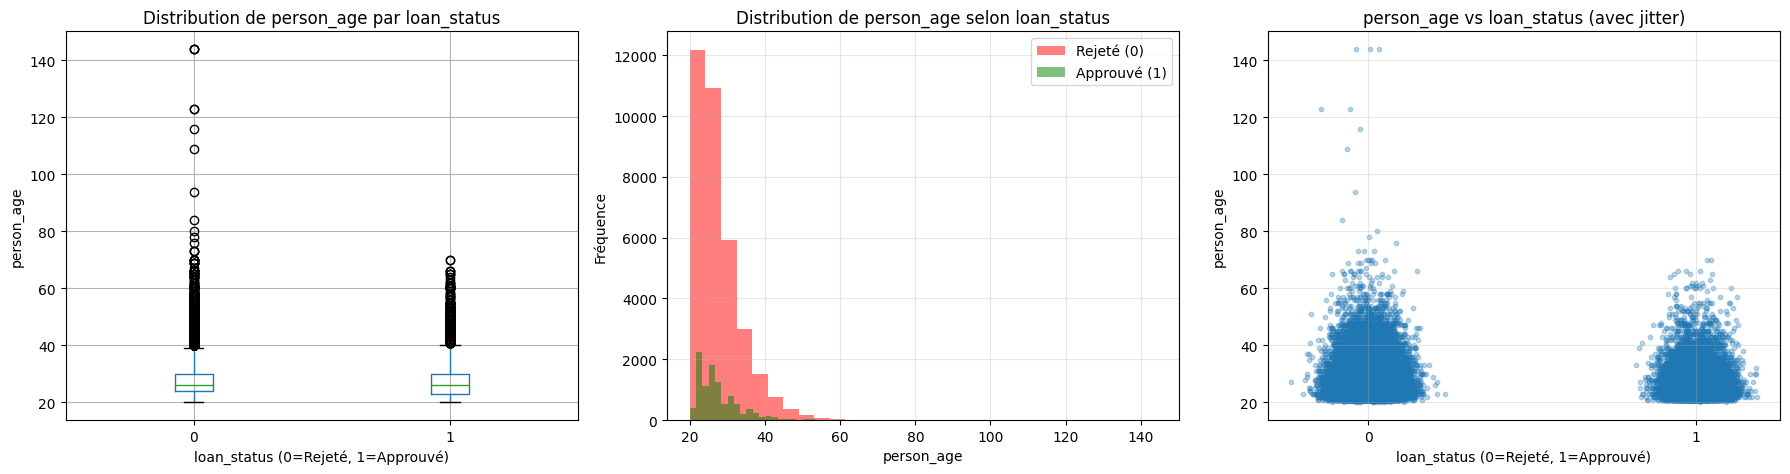


📊 INTERPRÉTATION :
  • Corrélation très faible (-0.021) → peu d'effet de l'âge
  • L'âge n'est pas un facteur discriminant dans ce dataset

────────────────────────────────────────────────────────────────────────────────
Variable : person_emp_exp
Corrélation avec loan_status : -0.020
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives par loan_status :
               count      mean       std  min  25%  50%  75%    max
loan_status                                                        
0            35000.0  5.476714  6.104261  0.0  1.0  4.0  8.0  125.0
1            10000.0  5.178000  5.913207  0.0  1.0  3.0  8.0   47.0

Test de Student (différence de moyennes) :
  • Statistique t : 4.346
  • p-value : 1.3923e-05
  • Conclusion : Différence SIGNIFICATIVE


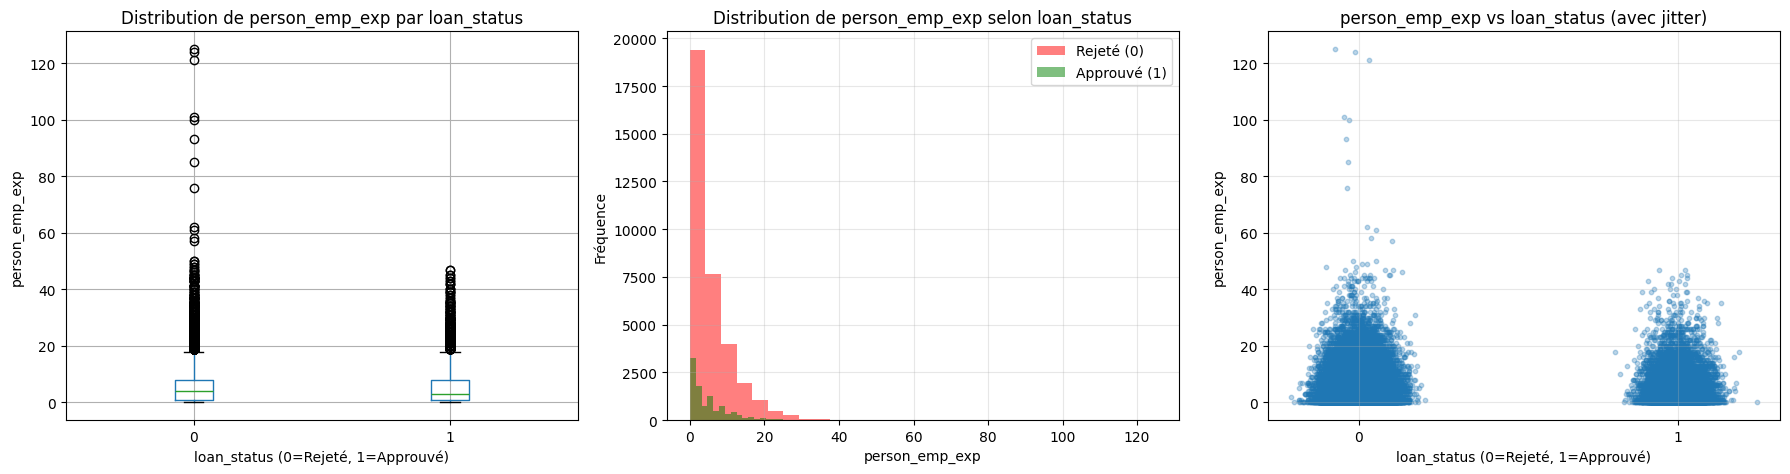


📊 INTERPRÉTATION :
  • Corrélation très faible (-0.020) → peu d'effet de l'expérience
  • L'expérience professionnelle n'est pas un facteur discriminant


3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES

Création d'un pairplot des variables significatives...


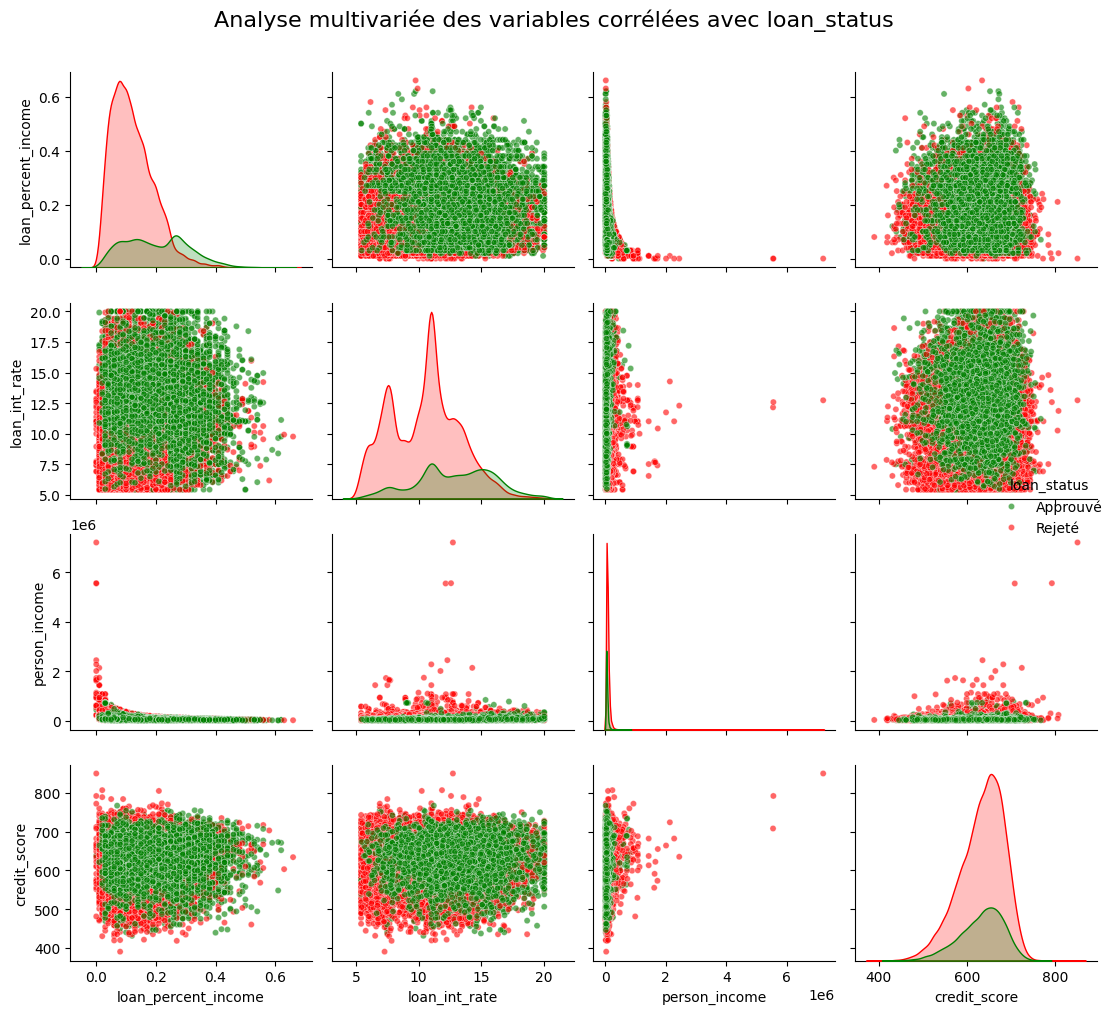


Matrice de corrélation des variables significatives :


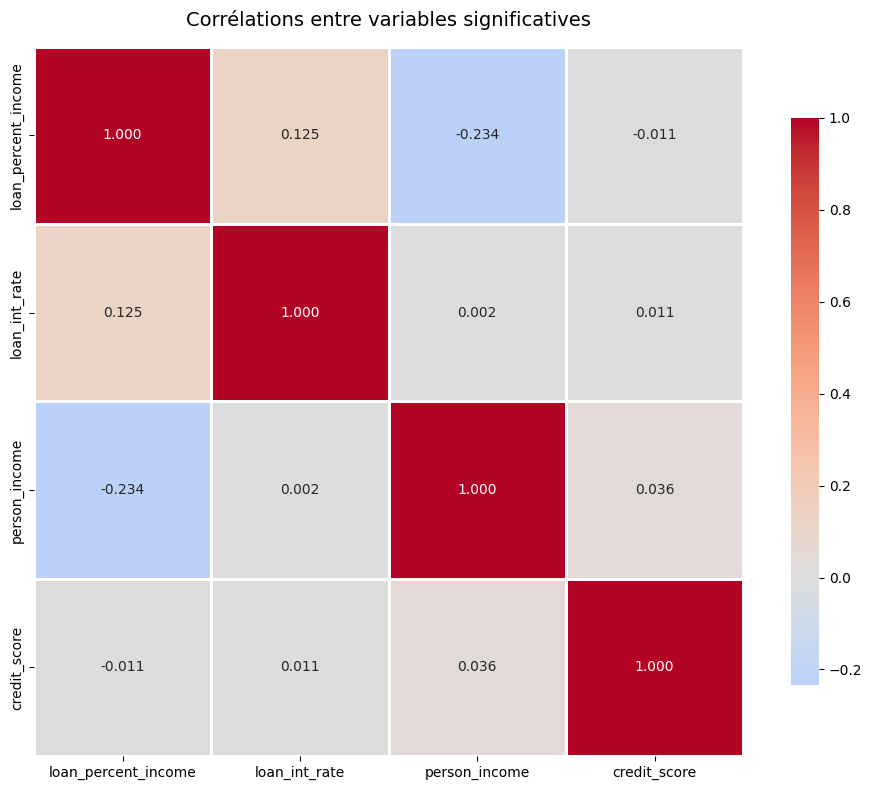

In [11]:
### Analyse détaillée des corrélations significatives

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Variables à analyser en détail
variables_to_analyze = {
    'positive': ['loan_percent_income', 'loan_int_rate'],
    'negative': ['person_income', 'credit_score', 'person_age', 'person_emp_exp']
}

print("="*80)
print("ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS")
print("="*80)

# ============================================================================
# PARTIE 1 : CORRÉLATIONS POSITIVES (favorisent l'approbation)
# ============================================================================

print("\n" + "="*80)
print("1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)")
print("="*80)

for var in variables_to_analyze['positive']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"\n{'─'*80}")
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    print(f"{'─'*80}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    from scipy.stats import ttest_ind
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interprétation contextuelle
    print(f"\n📊 INTERPRÉTATION :")
    if var == 'loan_percent_income':
        print(f"  • Les prêts approuvés ont un ratio prêt/revenu PLUS ÉLEVÉ en moyenne")
        print(f"  • Cela peut sembler contre-intuitif, mais peut indiquer :")
        print(f"    - Les personnes approuvées empruntent des montants plus importants relativement à leur revenu")
        print(f"    - Les banques acceptent des ratios plus élevés pour certains profils (ex: revenus stables)")
        print(f"    - Possible biais dans les données synthétiques")
    elif var == 'loan_int_rate':
        print(f"  • Les prêts approuvés ont des TAUX D'INTÉRÊT PLUS ÉLEVÉS en moyenne")
        print(f"  • Interprétation possible :")
        print(f"    - Les banques compensent le risque par des taux plus élevés")
        print(f"    - Les profils à risque acceptent des taux plus élevés pour obtenir le prêt")
        print(f"    - Corrélation ne signifie pas causalité : d'autres facteurs peuvent intervenir")

# ============================================================================
# PARTIE 2 : CORRÉLATIONS NÉGATIVES (défavorisent l'approbation)
# ============================================================================

print("\n\n" + "="*80)
print("2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)")
print("="*80)

for var in variables_to_analyze['negative']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"\n{'─'*80}")
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    print(f"{'─'*80}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interprétation contextuelle
    print(f"\n📊 INTERPRÉTATION :")
    if var == 'person_income':
        print(f"  • Les prêts approuvés ont des REVENUS PLUS FAIBLES en moyenne")
        print(f"  • Cela peut sembler contre-intuitif, mais peut indiquer :")
        print(f"    - Les hauts revenus ont moins besoin d'emprunter")
        print(f"    - Les hauts revenus empruntent via d'autres canaux (banques privées)")
        print(f"    - Biais dans les données synthétiques")
    elif var == 'credit_score':
        print(f"  • Les prêts approuvés ont des SCORES DE CRÉDIT PLUS FAIBLES en moyenne")
        print(f"  • ⚠️ ATTENTION : cela est très contre-intuitif !")
        print(f"  • Possible explication :")
        print(f"    - Artefact des données synthétiques (SMOTENC)")
        print(f"    - À vérifier en production avec des données réelles")
    elif var == 'person_age':
        print(f"  • Corrélation très faible ({corr:.3f}) → peu d'effet de l'âge")
        print(f"  • L'âge n'est pas un facteur discriminant dans ce dataset")
    elif var == 'person_emp_exp':
        print(f"  • Corrélation très faible ({corr:.3f}) → peu d'effet de l'expérience")
        print(f"  • L'expérience professionnelle n'est pas un facteur discriminant")

# ============================================================================
# PARTIE 3 : ANALYSE MULTIVARIÉE
# ============================================================================

print("\n\n" + "="*80)
print("3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES")
print("="*80)

# Pairplot des variables les plus corrélées
significant_vars = ['loan_percent_income', 'loan_int_rate', 'person_income', 'credit_score', 'loan_status']
pairplot_data = df[significant_vars].copy()
pairplot_data['loan_status'] = pairplot_data['loan_status'].map({0: 'Rejeté', 1: 'Approuvé'})

print("\nCréation d'un pairplot des variables significatives...")
g = sns.pairplot(pairplot_data, hue='loan_status', palette={'Rejeté': 'red', 'Approuvé': 'green'}, 
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
g.fig.suptitle('Analyse multivariée des variables corrélées avec loan_status', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

# Matrice de corrélation des variables significatives
print("\nMatrice de corrélation des variables significatives :")
corr_matrix = df[significant_vars[:-1]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Corrélations entre variables significatives', fontsize=14, pad=15)
plt.tight_layout()
plt.show()




🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status

                      Variable         Chi²       p-value  Cramér V Significatif (α=0.05)
         person_home_ownership  2989.514707  0.000000e+00  0.257747                 ✅ OUI
previous_loan_defaults_on_file 13270.288011  0.000000e+00  0.543043                 ✅ OUI
                   loan_intent   909.647678 2.173084e-194  0.142177                 ✅ OUI
              person_education     2.015940  7.328269e-01  0.006693                 ❌ NON
                 person_gender     0.011594  9.142540e-01  0.000508                 ❌ NON


💡 Interprétation des résultats:
• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)
• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)
• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)
  - V < 0.1 : négligeable
  - 0.1 ≤ V < 0.3 : faible
  - 0.3 ≤ V < 0.5 : modérée
  - V ≥ 0.5 : forte

📌 

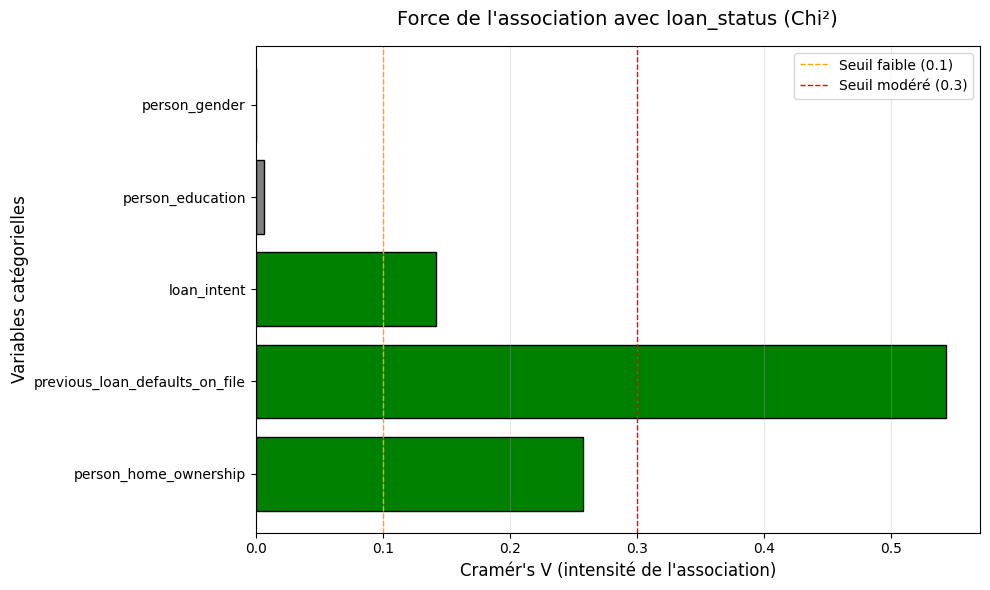

In [12]:
### 3. Test du Chi² pour variables catégorielles

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("\n🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status")
print("="*80)

# Stocker les résultats
chi2_results = []

# Tester chaque variable catégorielle (sauf loan_status elle-même)
for cat_var in cat_cols:
    if cat_var != 'loan_status':
        # Créer le tableau de contingence
        contingency_table = pd.crosstab(df[cat_var], df['loan_status'])
        
        # Effectuer le test du Chi²
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calculer le Cramér's V (mesure d'association normalisée)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Déterminer la significativité
        is_significant = "✅ OUI" if p_value < 0.05 else "❌ NON"
        
        chi2_results.append({
            'Variable': cat_var,
            'Chi²': chi2,
            'p-value': p_value,
            'Cramér V': cramers_v,
            'Significatif (α=0.05)': is_significant
        })

# Créer un DataFrame des résultats
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Afficher le tableau
print("\n" + chi2_df.to_string(index=False))

# Interprétation détaillée
print("\n\n💡 Interprétation des résultats:")
print("="*80)
print("• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)")
print("• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)")
print("• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)")
print("  - V < 0.1 : négligeable")
print("  - 0.1 ≤ V < 0.3 : faible")
print("  - 0.3 ≤ V < 0.5 : modérée")
print("  - V ≥ 0.5 : forte")

# Variables significatives
significant_cats = chi2_df[chi2_df['p-value'] < 0.05]
if len(significant_cats) > 0:
    print(f"\n📌 Variables catégorielles significatives: {len(significant_cats)}/{len(cat_cols)}")
    for _, row in significant_cats.iterrows():
        strength = "forte" if row['Cramér V'] >= 0.5 else "modérée" if row['Cramér V'] >= 0.3 else "faible"
        print(f"  • {row['Variable']}: p={row['p-value']:.4f}, V={row['Cramér V']:.3f} (association {strength})")
else:
    print("\n⚠️ Aucune variable catégorielle n'est significativement associée à loan_status")

# Visualisation du Cramér's V
plt.figure(figsize=(10, 6))
plt.barh(chi2_df['Variable'], chi2_df['Cramér V'], 
         color=['green' if p < 0.05 else 'gray' for p in chi2_df['p-value']],
         edgecolor='black')
plt.xlabel("Cramér's V (intensité de l'association)", fontsize=12)
plt.ylabel('Variables catégorielles', fontsize=12)
plt.title("Force de l'association avec loan_status (Chi²)", fontsize=14, pad=15)
plt.axvline(x=0.1, color='orange', linestyle='--', linewidth=1, label='Seuil faible (0.1)')
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=1, label='Seuil modéré (0.3)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS

────────────────────────────────────────────────────────────────────────────────
Variable : person_home_ownership
────────────────────────────────────────────────────────────────────────────────

📋 Tableau de contingence (effectifs bruts) :
loan_status                0      1    All
person_home_ownership                     
MORTGAGE               16345   2144  18489
OTHER                     78     39    117
OWN                     2729    222   2951
RENT                   15848   7595  23443
All                    35000  10000  45000

📊 Répartition de loan_status par modalité (en %) :
loan_status                0      1
person_home_ownership              
MORTGAGE               88.40  11.60
OTHER                  66.67  33.33
OWN                    92.48   7.52
RENT                   67.60  32.40

🔬 Test du Chi² :
  • Statistique χ² : 2989.51
  • Degrés de liberté : 3
  • p-value : 0.0000e+00
  • Cramér's V : 0.258
  •

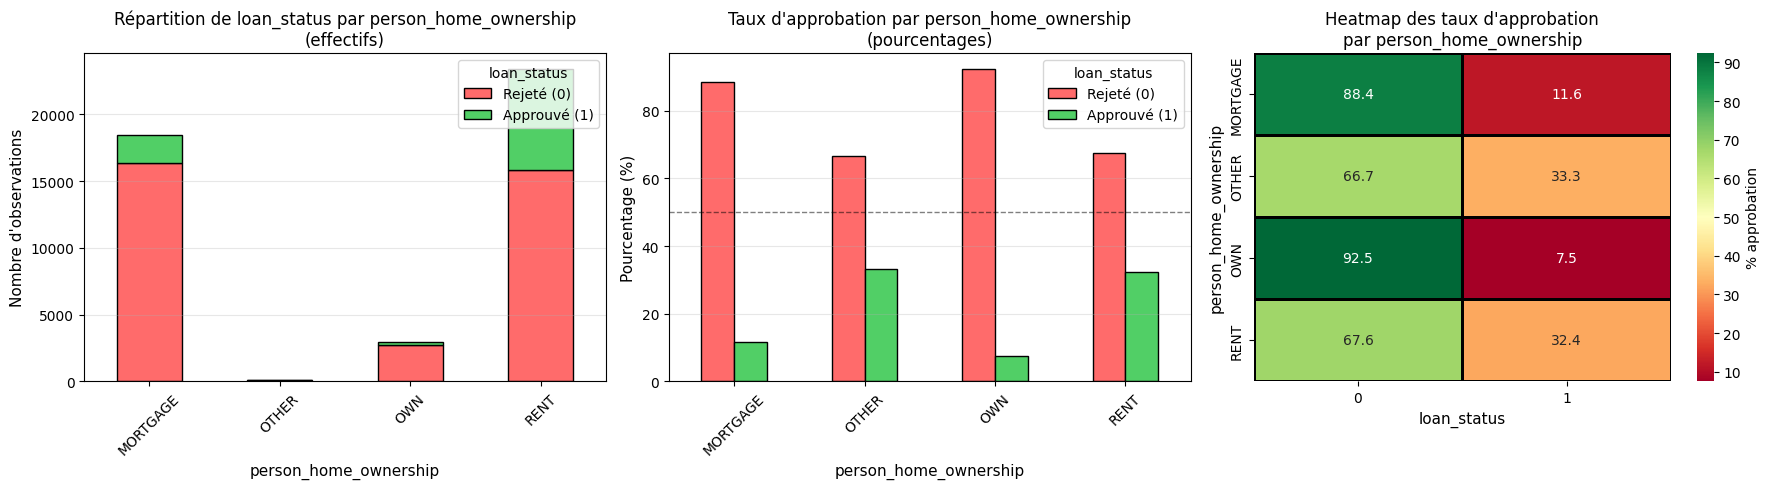


📈 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  RENT :
    • Effectif total : 23443
    • Approuvés : 7595 (32.4%)
    • Rejetés : 15848 (67.6%)
    ⚠️ Taux d'approbation SUPÉRIEUR de 10.2% à la moyenne (22.2%)

  OWN :
    • Effectif total : 2951
    • Approuvés : 222 (7.5%)
    • Rejetés : 2729 (92.5%)
    ⚠️ Taux d'approbation INFÉRIEUR de 14.7% à la moyenne (22.2%)

  MORTGAGE :
    • Effectif total : 18489
    • Approuvés : 2144 (11.6%)
    • Rejetés : 16345 (88.4%)
    ⚠️ Taux d'approbation INFÉRIEUR de 10.6% à la moyenne (22.2%)

  OTHER :
    • Effectif total : 117
    • Approuvés : 39 (33.3%)
    • Rejetés : 78 (66.7%)
    ⚠️ Taux d'approbation SUPÉRIEUR de 11.1% à la moyenne (22.2%)

────────────────────────────────────────────────────────────────────────────────
Variable : previous_loan_defaults_on_file
────────────────────────────────────────────────────────────────────────────────

📋 Tableau de contingence (effectifs brut

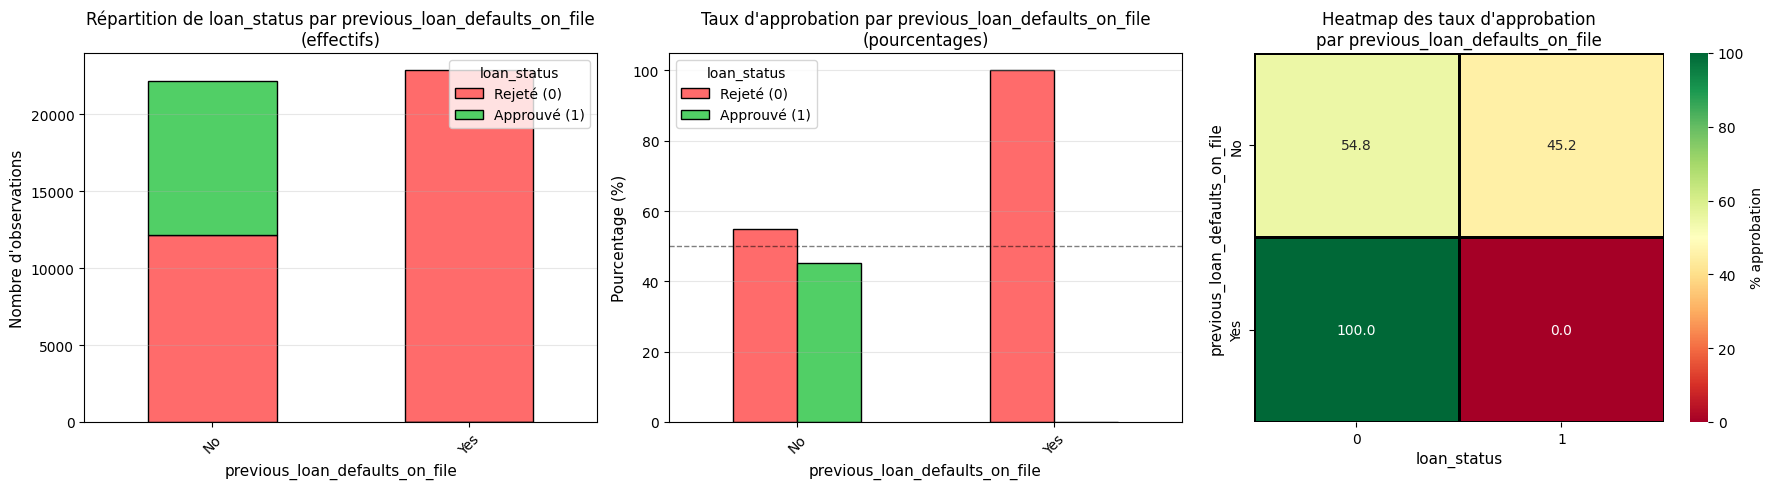


📈 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  No :
    • Effectif total : 22142
    • Approuvés : 10000 (45.2%)
    • Rejetés : 12142 (54.8%)
    ⚠️ Taux d'approbation SUPÉRIEUR de 22.9% à la moyenne (22.2%)

  Yes :
    • Effectif total : 22858
    • Approuvés : 0 (0.0%)
    • Rejetés : 22858 (100.0%)
    ⚠️ Taux d'approbation INFÉRIEUR de 22.2% à la moyenne (22.2%)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_intent
────────────────────────────────────────────────────────────────────────────────

📋 Tableau de contingence (effectifs bruts) :
loan_status            0      1    All
loan_intent                           
DEBTCONSOLIDATION   4982   2163   7145
EDUCATION           7601   1552   9153
HOMEIMPROVEMENT     3525   1258   4783
MEDICAL             6170   2378   8548
PERSONAL            6031   1521   7552
VENTURE             6691   1128   7819
All                35000  10000 

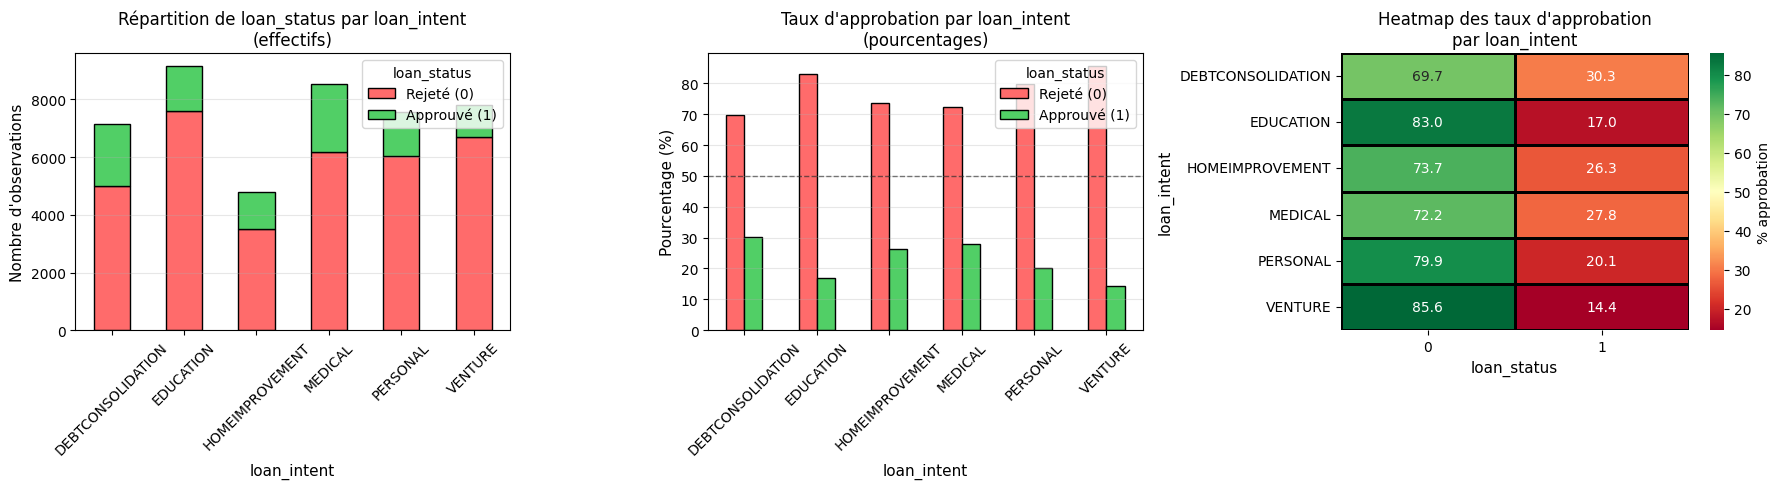


📈 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  PERSONAL :
    • Effectif total : 7552
    • Approuvés : 1521 (20.1%)
    • Rejetés : 6031 (79.9%)
    ✓ Taux d'approbation proche de la moyenne (22.2%)

  EDUCATION :
    • Effectif total : 9153
    • Approuvés : 1552 (17.0%)
    • Rejetés : 7601 (83.0%)
    ⚠️ Taux d'approbation INFÉRIEUR de 5.3% à la moyenne (22.2%)

  MEDICAL :
    • Effectif total : 8548
    • Approuvés : 2378 (27.8%)
    • Rejetés : 6170 (72.2%)
    ⚠️ Taux d'approbation SUPÉRIEUR de 5.6% à la moyenne (22.2%)

  VENTURE :
    • Effectif total : 7819
    • Approuvés : 1128 (14.4%)
    • Rejetés : 6691 (85.6%)
    ⚠️ Taux d'approbation INFÉRIEUR de 7.8% à la moyenne (22.2%)

  HOMEIMPROVEMENT :
    • Effectif total : 4783
    • Approuvés : 1258 (26.3%)
    • Rejetés : 3525 (73.7%)
    ✓ Taux d'approbation proche de la moyenne (22.2%)

  DEBTCONSOLIDATION :
    • Effectif total : 7145
    • Approuvés : 2163 (30.3%)
  

In [13]:
### Analyse détaillée des variables catégorielles significatives

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Variables catégorielles significatives identifiées
significant_categorical_vars = ['person_home_ownership', 'previous_loan_defaults_on_file', 'loan_intent']

print("="*80)
print("ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS")
print("="*80)

for cat_var in significant_categorical_vars:
    print(f"\n{'─'*80}")
    print(f"Variable : {cat_var}")
    print(f"{'─'*80}")
    
    # 1. Tableau de contingence
    contingency_table = pd.crosstab(df[cat_var], df['loan_status'], margins=True)
    print("\n📋 Tableau de contingence (effectifs bruts) :")
    print(contingency_table)
    
    # 2. Tableau en pourcentages (par ligne = par modalité)
    contingency_pct = pd.crosstab(df[cat_var], df['loan_status'], normalize='index') * 100
    print("\n📊 Répartition de loan_status par modalité (en %) :")
    print(contingency_pct.round(2))
    
    # 3. Test du Chi²
    contingency_no_margins = pd.crosstab(df[cat_var], df['loan_status'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_no_margins)
    
    # Calcul du Cramér's V
    n = contingency_no_margins.sum().sum()
    min_dim = min(contingency_no_margins.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    print(f"\n🔬 Test du Chi² :")
    print(f"  • Statistique χ² : {chi2:.2f}")
    print(f"  • Degrés de liberté : {dof}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Cramér's V : {cramers_v:.3f}")
    
    # Interprétation de la force
    if cramers_v >= 0.5:
        strength = "FORTE"
    elif cramers_v >= 0.3:
        strength = "MODÉRÉE"
    elif cramers_v >= 0.1:
        strength = "FAIBLE"
    else:
        strength = "NÉGLIGEABLE"
    
    print(f"  • Force de l'association : {strength}")
    print(f"  • Conclusion : {'Association SIGNIFICATIVE' if p_value < 0.05 else 'Pas d association significative'}")
    
    # 4. Visualisations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4.1. Graphique en barres empilées (effectifs)
    ax1 = axes[0]
    contingency_no_margins.plot(kind='bar', stacked=True, ax=ax1, 
                                color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax1.set_title(f'Répartition de loan_status par {cat_var}\n(effectifs)', fontsize=12)
    ax1.set_xlabel(cat_var, fontsize=11)
    ax1.set_ylabel('Nombre d\'observations', fontsize=11)
    ax1.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='upper right')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 4.2. Graphique en barres groupées (pourcentages)
    ax2 = axes[1]
    contingency_pct.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax2.set_title(f'Taux d\'approbation par {cat_var}\n(pourcentages)', fontsize=12)
    ax2.set_xlabel(cat_var, fontsize=11)
    ax2.set_ylabel('Pourcentage (%)', fontsize=11)
    ax2.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='best')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(axis='y', alpha=0.3)
    
    # 4.3. Heatmap du tableau de contingence normalisé
    ax3 = axes[2]
    sns.heatmap(contingency_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=50, ax=ax3, cbar_kws={'label': '% approbation'},
                linewidths=1, linecolor='black')
    ax3.set_title(f'Heatmap des taux d\'approbation\npar {cat_var}', fontsize=12)
    ax3.set_xlabel('loan_status', fontsize=11)
    ax3.set_ylabel(cat_var, fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Analyse détaillée par modalité
    print(f"\n📈 Analyse détaillée par modalité :")
    print(f"{'─'*60}")
    
    for modality in df[cat_var].unique():
        subset = df[df[cat_var] == modality]
        approval_rate = (subset['loan_status'] == 1).mean() * 100
        n_obs = len(subset)
        n_approved = (subset['loan_status'] == 1).sum()
        n_rejected = (subset['loan_status'] == 0).sum()
        
        print(f"\n  {modality} :")
        print(f"    • Effectif total : {n_obs}")
        print(f"    • Approuvés : {n_approved} ({approval_rate:.1f}%)")
        print(f"    • Rejetés : {n_rejected} ({100-approval_rate:.1f}%)")
        
        # Comparaison avec la moyenne globale
        global_approval_rate = (df['loan_status'] == 1).mean() * 100
        diff = approval_rate - global_approval_rate
        
        if abs(diff) > 5:  # Seuil de 5% de différence
            if diff > 0:
                print(f"    ⚠️ Taux d'approbation SUPÉRIEUR de {diff:.1f}% à la moyenne ({global_approval_rate:.1f}%)")
            else:
                print(f"    ⚠️ Taux d'approbation INFÉRIEUR de {abs(diff):.1f}% à la moyenne ({global_approval_rate:.1f}%)")
        else:
            print(f"    ✓ Taux d'approbation proche de la moyenne ({global_approval_rate:.1f}%)")
    


### Rééquilibrage de la target — pourquoi l'undersampling ?

Ici, nous choisissons d'équilibrer la target `loan_status` par undersampling des classes majoritaires (réduction du nombre d'exemples des classes abondantes) afin d'obtenir des classes approximativement équilibrées.

Points importants :
- L'undersampling évite d'ajouter des exemples synthétiques mais réduit la taille totale du jeu de données.
- Si la classe minoritaire est très petite, l'undersampling peut trop appauvrir l'entraînement.
- Alternative : l'upsampling, SMOTE, ou l'utilisation de `class_weight='balanced'` dans les modèles. On ne l'utilisera pas ici

Exécutez ensuite la cellule qui suit (qui réalise l'undersampling) pour appliquer le rééquilibrage au DataFrame `df`.

In [14]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


Distribution avant (counts):
loan_status
0    35000
1    10000
Name: count, dtype: int64
Distribution après (équilibrée):
loan_status
1    10000
0    10000
Name: count, dtype: int64


### Après l'undersampling — remarques et vérifications

Cette cellule réalise l'undersampling effectif et remplace `df` par la version sous-échantillonnée.

On vérifie :
- la distribution imprimée (`value_counts`) pour s'assurer d'un bon rééquilibrage ;
- la taille totale du DataFrame (ex. `df.shape`) : elle diminuera si l'undersampling a retiré des exemples ;
- si vous souhaitez conserver `df` non modifié pour des comparaisons, faites une copie avant (`df_original = df.copy()`).

La cellule suivante construit `X` et `y` à partir de `df` (donc utilisera les données rééquilibrées).

In [15]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


## Modélisation pour Logisitic Regression : pipeline + GridSearchCV

But : construire un pipeline complet (préprocesseur + classifieur) et rechercher le meilleur hyperparamètre `C` pour la Logistic Regression via GridSearchCV.

- `GridSearchCV` est ici limité (recherche sur 4 valeurs de `C`) pour rester rapide ; étendez la grille si nécessaire.

Après entraînement, on récupère le meilleur estimateur et on prédit sur l'ensemble test pour obtenir les métriques affichées ensuite.

In [16]:
# Modèle: pipeline simple avec preprocessor (sur toutes features) + LogisticRegression
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
param_grid = {'clf__C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best = gs.best_estimator_

# évaluer sur test
y_pred = best.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

Best params: {'clf__C': 10.0}
Test accuracy: 0.873

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      2000
           1       0.85      0.91      0.88      2000

    accuracy                           0.87      4000
   macro avg       0.88      0.87      0.87      4000
weighted avg       0.88      0.87      0.87      4000



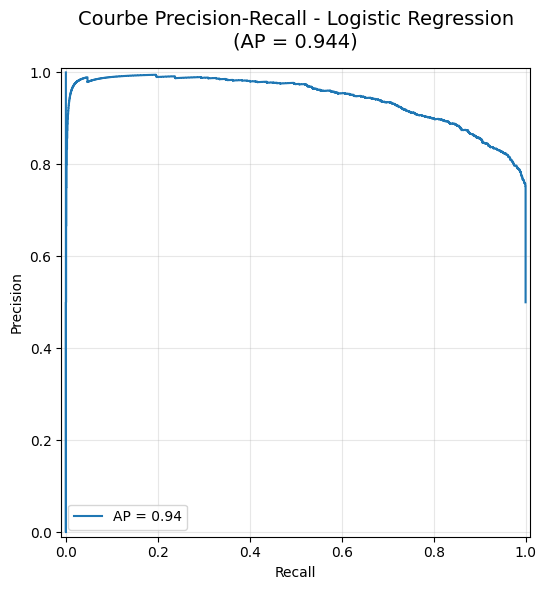

Average Precision Score: 0.9445

📊 Analyse des seuils de décision:
Seuil = 0.000 → Precision = 0.500, Recall = 1.000
Seuil = 0.000 → Precision = 0.667, Recall = 1.000
Seuil = 0.601 → Precision = 0.874, Recall = 0.874
Seuil = 0.919 → Precision = 0.977, Recall = 0.488
Seuil = 1.000 → Precision = 1.000, Recall = 0.000


In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# Calculer les probabilités prédites (nécessaires pour la courbe Precision-Recall)
y_proba = best.predict_proba(X_test)[:, 1]

# Calculer la courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

# Tracer la courbe Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
display = PrecisionRecallDisplay(precision=precision, recall=recall, 
                                  average_precision=average_precision)
display.plot(ax=ax)
ax.set_title(f'Courbe Precision-Recall - Logistic Regression\n(AP = {average_precision:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Average Precision Score: {average_precision:.4f}')

# Analyser différents seuils de décision
print('\n📊 Analyse des seuils de décision:')
print('='*60)
# Sélectionner quelques seuils représentatifs
threshold_indices = [0, len(thresholds)//4, len(thresholds)//2, 3*len(thresholds)//4, -1]
for idx in threshold_indices:
    if idx < len(thresholds):
        print(f'Seuil = {thresholds[idx]:.3f} → Precision = {precision[idx]:.3f}, Recall = {recall[idx]:.3f}')

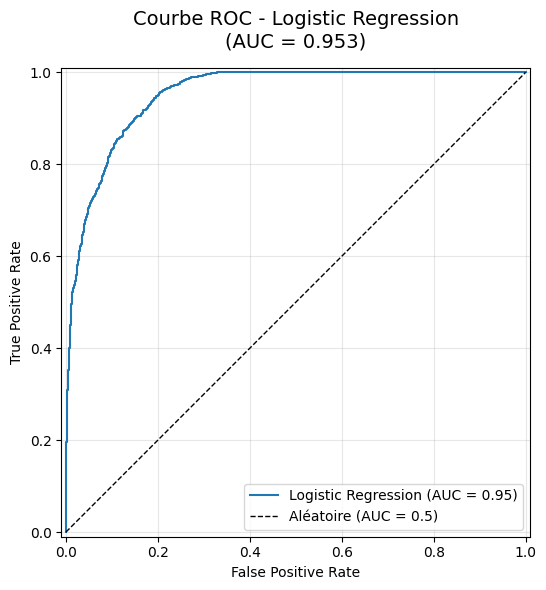

ROC AUC Score: 0.9526

📊 Analyse des seuils de décision (ROC):
Seuil = inf → FPR = 0.000, TPR (Recall) = 0.000
Seuil = 0.822 → FPR = 0.049, TPR (Recall) = 0.697
Seuil = 0.671 → FPR = 0.103, TPR (Recall) = 0.836
Seuil = 0.420 → FPR = 0.188, TPR (Recall) = 0.938
Seuil = 0.000 → FPR = 1.000, TPR (Recall) = 1.000

📈 Comparaison des métriques:
Average Precision (PR curve): 0.9445
ROC AUC Score (ROC curve):    0.9526

💡 Interprétation:
  • ROC AUC proche de 1.0 = excellent modèle
  • ROC AUC = 0.5 = modèle aléatoire (ligne diagonale)
  • La courbe ROC est moins sensible au déséquilibre de classes
  • La courbe Precision-Recall est plus informative pour les classes déséquilibrées


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Calculer la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Tracer la courbe ROC
fig, ax = plt.subplots(figsize=(8, 6))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
ax.set_title(f'Courbe ROC - Logistic Regression\n(AUC = {roc_auc:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')

# Analyser différents seuils pour la courbe ROC
print('\n📊 Analyse des seuils de décision (ROC):')
print('='*60)
# Sélectionner quelques seuils représentatifs
roc_threshold_indices = [0, len(roc_thresholds)//4, len(roc_thresholds)//2, 3*len(roc_thresholds)//4, -1]
for idx in roc_threshold_indices:
    if idx < len(roc_thresholds):
        print(f'Seuil = {roc_thresholds[idx]:.3f} → FPR = {fpr[idx]:.3f}, TPR (Recall) = {tpr[idx]:.3f}')

# Comparaison Precision-Recall vs ROC
print('\n📈 Comparaison des métriques:')
print('='*60)
print(f'Average Precision (PR curve): {average_precision:.4f}')
print(f'ROC AUC Score (ROC curve):    {roc_auc:.4f}')
print('\n💡 Interprétation:')
print('  • ROC AUC proche de 1.0 = excellent modèle')
print('  • ROC AUC = 0.5 = modèle aléatoire (ligne diagonale)')
print('  • La courbe ROC est moins sensible au déséquilibre de classes')
print('  • La courbe Precision-Recall est plus informative pour les classes déséquilibrées')

### Évaluation : métriques et matrice de confusion

- On affiche la précision, le rapport de classification (precision, recall, f1) et la matrice de confusion.
- La matrice de confusion montre les faux positifs / faux négatifs — utiles pour comprendre les erreurs du modèle.
- En contexte d'octroi de prêt, préférez souvent optimiser le recall sur la classe « prêt accordé » ou « refusé » selon le coût des erreurs.

Ensuite, une cellule trace la matrice de confusion (matplotlib).

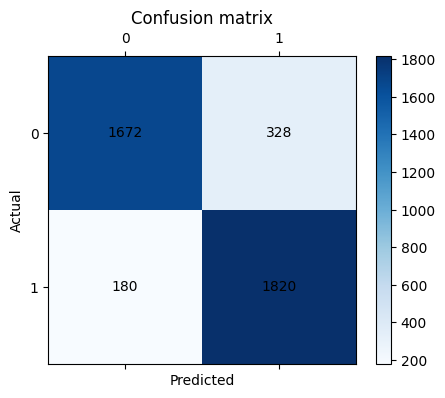

In [19]:
# Matrice de confusion (matplotlib)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels = np.unique(y_test)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([str(l) for l in labels])
ax.set_yticklabels([str(l) for l in labels])
fig.colorbar(cax)
plt.title('Confusion matrix')
plt.show()

In [20]:
# Sauvegarder le meilleur modèle
joblib.dump(best, 'logistic_regression_basic_model.joblib')
print('Modèle sauvegardé: logistic_regression_basic_model.joblib')

# Conclusion rapide
print('\nTerminé — consultez les cellules précédentes pour les métriques et la matrice de confusion.')

Modèle sauvegardé: logistic_regression_basic_model.joblib

Terminé — consultez les cellules précédentes pour les métriques et la matrice de confusion.


## Modélisation pour Random Forest : preprocessing et gridsearch

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec RandomForest
pipe_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# GridSearch pour RandomForest
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print('Best params:', gs_rf.best_params_)
best_rf = gs_rf.best_estimator_

# Évaluation sur test
y_pred_rf = best_rf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nClassification report:\n', classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Test accuracy: 0.89925

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      2000
           1       0.88      0.92      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Test accuracy: 0.89925

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      2000
           1       0.88      0.92      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



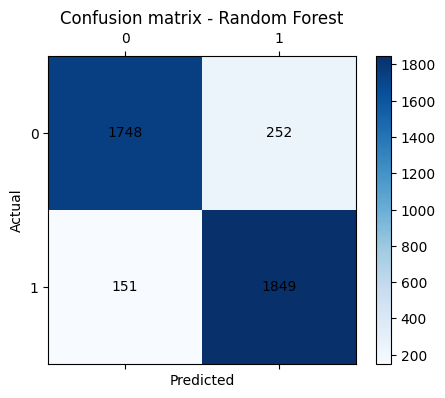

In [22]:
# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_rf, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_rf):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_rf = np.unique(y_test)
ax.set_xticks(range(len(labels_rf)))
ax.set_yticks(range(len(labels_rf)))
ax.set_xticklabels([str(l) for l in labels_rf])
ax.set_yticklabels([str(l) for l in labels_rf])
fig.colorbar(cax)
plt.title('Confusion matrix - Random Forest')
plt.show()

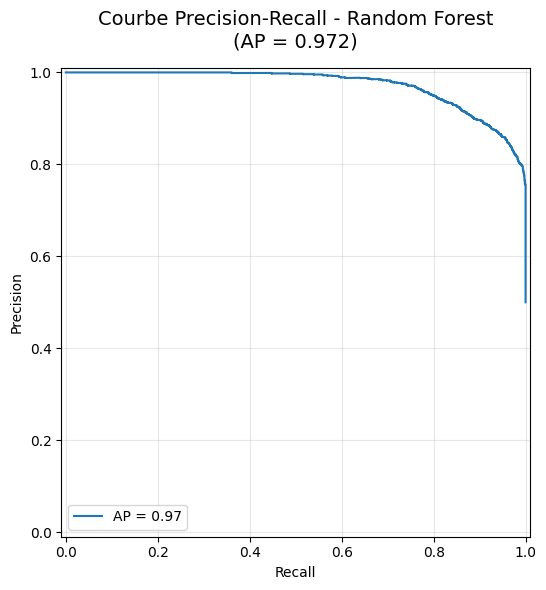

Average Precision Score: 0.9724

📊 Analyse des seuils de décision (Precision-Recall):
Seuil = 0.000 → Precision = 0.500, Recall = 1.000
Seuil = 0.479 → Precision = 0.874, Recall = 0.936
Seuil = 0.781 → Precision = 0.975, Recall = 0.734
Seuil = 0.948 → Precision = 0.999, Recall = 0.432
Seuil = 1.000 → Precision = 1.000, Recall = 0.000


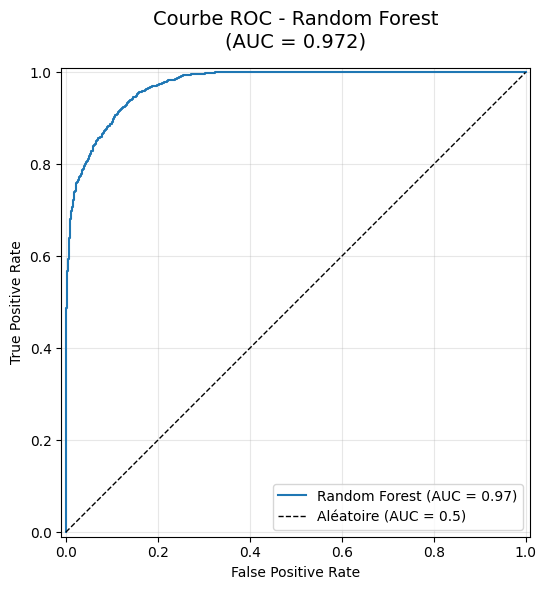


ROC AUC Score: 0.9723

📊 Analyse des seuils de décision (ROC):
Seuil = inf → FPR = 0.000, TPR (Recall) = 0.000
Seuil = 0.811 → FPR = 0.014, TPR (Recall) = 0.706
Seuil = 0.609 → FPR = 0.081, TPR (Recall) = 0.868
Seuil = 0.400 → FPR = 0.173, TPR (Recall) = 0.961
Seuil = 0.000 → FPR = 1.000, TPR (Recall) = 1.000


In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay



# Calculer les probabilités prédites
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Calculer la courbe Precision-Recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)
average_precision_rf = average_precision_score(y_test, y_proba_rf)

# Tracer la courbe Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
display = PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf, 
                                  average_precision=average_precision_rf)
display.plot(ax=ax)
ax.set_title(f'Courbe Precision-Recall - Random Forest\n(AP = {average_precision_rf:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Average Precision Score: {average_precision_rf:.4f}')

# Analyser différents seuils de décision
print('\n📊 Analyse des seuils de décision (Precision-Recall):')
print('='*60)
threshold_indices = [0, len(thresholds_rf)//4, len(thresholds_rf)//2, 3*len(thresholds_rf)//4, -1]
for idx in threshold_indices:
    if idx < len(thresholds_rf):
        print(f'Seuil = {thresholds_rf[idx]:.3f} → Precision = {precision_rf[idx]:.3f}, Recall = {recall_rf[idx]:.3f}')

# ============================================================================
# COURBE ROC - RANDOM FOREST
# ============================================================================

# Calculer la courbe ROC
fpr_rf, tpr_rf, roc_thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Tracer la courbe ROC
fig, ax = plt.subplots(figsize=(8, 6))
display = RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, 
                          estimator_name='Random Forest')
display.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
ax.set_title(f'Courbe ROC - Random Forest\n(AUC = {roc_auc_rf:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'\nROC AUC Score: {roc_auc_rf:.4f}')

# Analyser différents seuils pour la courbe ROC
print('\n📊 Analyse des seuils de décision (ROC):')
print('='*60)
roc_threshold_indices = [0, len(roc_thresholds_rf)//4, len(roc_thresholds_rf)//2, 
                         3*len(roc_thresholds_rf)//4, -1]
for idx in roc_threshold_indices:
    if idx < len(roc_thresholds_rf):
        print(f'Seuil = {roc_thresholds_rf[idx]:.3f} → FPR = {fpr_rf[idx]:.3f}, TPR (Recall) = {tpr_rf[idx]:.3f}')



In [24]:
# Sauvegarder le meilleur modèle Random Forest
joblib.dump(best_rf, 'random_forest_model.joblib')
print('Modèle Random Forest sauvegardé: random_forest_model.joblib')

Modèle Random Forest sauvegardé: random_forest_model.joblib


On observe que le recall pour l'approbation est meilleur que l'accuracy.

# Pipeline avec LightGBM

In [25]:
from lightgbm import LGBMClassifier

# Pipeline avec LightGBM (pas besoin de libomp !)
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', LGBMClassifier(random_state=42, verbose=-1))
])

# GridSearch pour LightGBM
param_grid_lgbm = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 7, -1],           # -1 = pas de limite
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1.0]
}

gs_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_lgbm.fit(X_train, y_train)

print('Best params:', gs_lgbm.best_params_)
best_lgbm = gs_lgbm.best_estimator_

# Évaluation sur test
y_pred_lgbm = best_lgbm.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_lgbm))
print('\nClassification report:\n', classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Test accuracy: 0.90675

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      2000
           1       0.90      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Test accuracy: 0.90675

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      2000
           1       0.90      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.

## Pipeline avec XGBoost

In [26]:
from xgboost import XGBClassifier

# Pipeline avec XGBoost (sans restriction de thread)
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))  # ← Retire nthread=1
])

# GridSearch avec parallélisme complet
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1.0]
}

# ✅ n_jobs=-1 utilise tous les cœurs CPU
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print('Best params:', gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_

# Évaluation sur test
y_pred_xgb = best_xgb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))
print('\nClassification report:\n', classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Test accuracy: 0.906

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2000
           1       0.89      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

Best params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Test accuracy: 0.906

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2000
           1       0.89      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91  

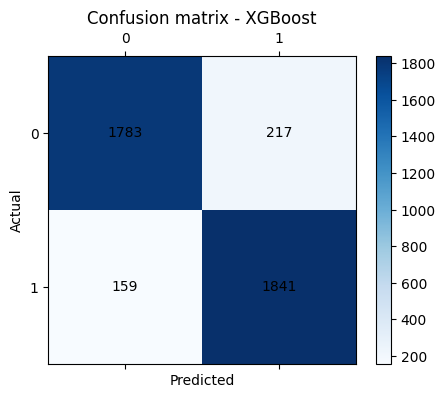

In [27]:
# Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_xgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_xgb):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_xgb = np.unique(y_test)
ax.set_xticks(range(len(labels_xgb)))
ax.set_yticks(range(len(labels_xgb)))
ax.set_xticklabels([str(l) for l in labels_xgb])
ax.set_yticklabels([str(l) for l in labels_xgb])
fig.colorbar(cax)
plt.title('Confusion matrix - XGBoost')
plt.show()

In [28]:
# Sauvegarder le meilleur modèle XGBoost
joblib.dump(best_xgb, 'xgboost_model.joblib')
print('Modèle XGBoost sauvegardé: xgboost_model.joblib')

Modèle XGBoost sauvegardé: xgboost_model.joblib


#### Sauvegarde

Conclusion rapide : interprétez les métriques et décidez si vous souhaitez :
- récupérer plus de données (si l'undersampling a trop réduit le jeu),
- tester d'autres modèles (RandomForest, XGBoost),
- affiner la grille d'hyperparamètres ou utiliser une validation croisée imbriquée pour une estimation plus robuste.

# Réseau de neurones (PyTorch)
Dans cette section, nous construisons un réseau de neurones entièrement connecté (*Multi-Layer Perceptron*) en utilisant PyTorch, afin de proposer une alternative plus flexible aux modèles classiques (Logistic Regression, SVM, KNN, etc.).

Ce réseau intègre plusieurs bonnes pratiques issues du deep learning moderne :

- **GELU** : une activation plus performante que ReLU pour les réseaux profonds.  
- **Batch Normalization** : stabilise et accélère l'entraînement.  
- **Dropout** : régularisation légère pour réduire le surapprentissage.  
- **Skip Connection (résiduelle)** : améliore la propagation du gradient.  
- **Projection du skip** : permet d'additionner des tenseurs de dimensions différentes (128 → 64).  
- **Initialisation Kaiming/He** : adaptée aux activations GELU/LeakyReLU.  
- **Gradient Clipping** : évite l'exploding gradient.  
- **OneCycleLR** : scheduler moderne permettant une convergence plus rapide et plus stable.  
- **Early Stopping** : arrête l'entraînement dès que la perte ne s'améliore plus.

L'objectif est d'obtenir un modèle **plus robuste**, **plus performant** et **plus proche des standards actuels** du deep learning, tout en restant simple à comprendre.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# -------------------------------------------------------------------
# Préparation des données : conversion explicite en valeurs numériques
# -------------------------------------------------------------------
# PyTorch ne gère pas les types "object" : on force tous les champs à devenir numériques.
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

# Conversion en tenseurs PyTorch
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

# Création du DataLoader pour gérer les batches
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -------------------------------------------------------------------
# Définition du réseau de neurones
# - Deux blocs fully connected
# - BatchNorm + GELU + Dropout
# - Skip connection avec projection (128 -> 64)
# -------------------------------------------------------------------
class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # Premier bloc dense
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Deuxième bloc dense
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Projection du skip (128 vers 64)
        self.skip_proj = nn.Linear(128, 64)

        # Couche de sortie
        self.output = nn.Linear(64, 2)

        # Initialisation He/Kaiming
        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity="leaky_relu")
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        skip = self.skip_proj(x)
        x = self.layer2(x) + skip
        return self.output(x)

# Instanciation du modèle
mlp = DeepMLP(X_train.shape[1])

# -------------------------------------------------------------------
# Configuration de l'entraînement
# -------------------------------------------------------------------

optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Scheduler OneCycleLR pour améliorer la convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=20
)

criterion = nn.CrossEntropyLoss()

# Early stopping
best_loss = float("inf")
patience = 4
counter = 0

# -------------------------------------------------------------------
# Boucle d'entraînement
# -------------------------------------------------------------------
EPOCHS = 20
for epoch in range(EPOCHS):
    mlp.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        preds = mlp(xb)
        loss = criterion(preds, yb)
        loss.backward()

        # Coupe les gradients trop grands
        nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {epoch_loss/len(train_loader):.4f}")

    # Early stopping basé sur la perte d'entraînement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
        best_model_state = mlp.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping déclenché.")
            break

# Chargement du meilleur modèle sauvegardé
mlp.load_state_dict(best_model_state)

# -------------------------------------------------------------------
# Évaluation finale
# -------------------------------------------------------------------
mlp.eval()
with torch.no_grad():
    preds_test = mlp(X_test_t).argmax(1).numpy()

print("\nPerformance du réseau de neurones :")
print("Accuracy:", accuracy_score(y_test, preds_test))
print("\nMatrice de confusion:\n", confusion_matrix(y_test, preds_test))
print("\nRapport de classification:\n", classification_report(y_test, preds_test))


Epoch 1/20 — Loss: 0.6330
Epoch 2/20 — Loss: 0.6083
Epoch 2/20 — Loss: 0.6083
Epoch 3/20 — Loss: 0.5912
Epoch 3/20 — Loss: 0.5912
Epoch 4/20 — Loss: 0.5905
Epoch 4/20 — Loss: 0.5905
Epoch 5/20 — Loss: 0.5908
Epoch 5/20 — Loss: 0.5908
Epoch 6/20 — Loss: 0.5858
Epoch 6/20 — Loss: 0.5858
Epoch 7/20 — Loss: 0.5856
Epoch 7/20 — Loss: 0.5856
Epoch 8/20 — Loss: 0.5816
Epoch 8/20 — Loss: 0.5816
Epoch 9/20 — Loss: 0.5796
Epoch 9/20 — Loss: 0.5796
Epoch 10/20 — Loss: 0.5792
Epoch 10/20 — Loss: 0.5792
Epoch 11/20 — Loss: 0.5777
Epoch 11/20 — Loss: 0.5777
Epoch 12/20 — Loss: 0.5745
Epoch 12/20 — Loss: 0.5745
Epoch 13/20 — Loss: 0.5756
Epoch 13/20 — Loss: 0.5756
Epoch 14/20 — Loss: 0.5721
Epoch 14/20 — Loss: 0.5721
Epoch 15/20 — Loss: 0.5723
Epoch 15/20 — Loss: 0.5723
Epoch 16/20 — Loss: 0.5711
Epoch 16/20 — Loss: 0.5711
Epoch 17/20 — Loss: 0.5524
Epoch 17/20 — Loss: 0.5524
Epoch 18/20 — Loss: 0.5257
Epoch 18/20 — Loss: 0.5257
Epoch 19/20 — Loss: 0.5060
Epoch 19/20 — Loss: 0.5060
Epoch 20/20 — Loss

# Analyse de l'influence des hyperparamètres sur les modèles

## Contexte et objectifs

Les hyperparamètres sont les paramètres de configuration d'un modèle qui ne sont **pas appris** pendant l'entraînement, mais définis **avant** le processus d'apprentissage. Leur tuning (ajustement) est crucial pour optimiser les performances du modèle.

### Questions clés

- Quel est l'impact de chaque hyperparamètre sur les performances (F1-score, accuracy, recall, precision) ?
- Existe-t-il des interactions entre hyperparamètres ?
- Quel ensemble d'hyperparamètres offre le meilleur équilibre entre performance et généralisation ?

### Approche méthodologique

Pour chaque modèle, nous allons :
1. **Visualiser la grille de recherche** : tableau des hyperparamètres testés
2. **Tracer les courbes de performance** : impact de chaque hyperparamètre individuellement
3. **Analyser les interactions** : comment les hyperparamètres se comportent ensemble
4. **Comparer les modèles** : quel modèle offre les meilleures performances pour quels hyperparamètres

In [ ]:
## 1. Récapitulatif des hyperparamètres testés et résultats

# Afficher les meilleurs hyperparamètres pour chaque modèle
models_info = {
    'Logistic Regression': {
        'best_params': gs.best_params_,
        'best_score': gs.best_score_,
        'cv_results': gs.cv_results_,
        'model': best
    },
    'Random Forest': {
        'best_params': gs_rf.best_params_,
        'best_score': gs_rf.best_score_,
        'cv_results': gs_rf.cv_results_,
        'model': best_rf
    },
    'LightGBM': {
        'best_params': gs_lgbm.best_params_,
        'best_score': gs_lgbm.best_score_,
        'cv_results': gs_lgbm.cv_results_,
        'model': best_lgbm
    },
    'XGBoost': {
        'best_params': gs_xgb.best_params_,
        'best_score': gs_xgb.best_score_,
        'cv_results': gs_xgb.cv_results_,
        'model': best_xgb
    }
}

print("="*80)
print("RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES PAR MODÈLE")
print("="*80)

for model_name, info in models_info.items():
    print(f"\n{'─'*80}")
    print(f"📊 {model_name}")
    print(f"{'─'*80}")
    print(f"Meilleur F1-score (validation croisée) : {info['best_score']:.4f}")
    print(f"\nMeilleurs hyperparamètres :")
    for param, value in info['best_params'].items():
        print(f"  • {param}: {value}")
    
    # Évaluation sur l'ensemble de test
    y_pred_temp = info['model'].predict(X_test)
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(y_test, y_pred_temp)
    precision = precision_score(y_test, y_pred_temp)
    recall = recall_score(y_test, y_pred_temp)
    accuracy = accuracy_score(y_test, y_pred_temp)
    
    print(f"\nMétriques sur l'ensemble de test :")
    print(f"  • F1-score     : {f1:.4f}")
    print(f"  • Précision    : {precision:.4f}")
    print(f"  • Recall       : {recall:.4f}")
    print(f"  • Accuracy     : {accuracy:.4f}")

RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES PAR MODÈLE

────────────────────────────────────────────────────────────────────────────────
📊 Logistic Regression
────────────────────────────────────────────────────────────────────────────────
Meilleur F1-score (validation croisée) : 0.8787

Meilleurs hyperparamètres :
  • clf__C: 10.0

Métriques sur l'ensemble de test :
  • F1-score     : 0.8775
  • Précision    : 0.8473
  • Recall       : 0.9100
  • Accuracy     : 0.8730

────────────────────────────────────────────────────────────────────────────────
📊 Random Forest
────────────────────────────────────────────────────────────────────────────────
Meilleur F1-score (validation croisée) : 0.9020

Meilleurs hyperparamètres :
  • clf__max_depth: 20
  • clf__min_samples_split: 5
  • clf__n_estimators: 200

Métriques sur l'ensemble de test :
  • F1-score     : 0.9017
  • Précision    : 0.8801
  • Recall       : 0.9245
  • Accuracy     : 0.8992

────────────────────────────────────────────────────────


ANALYSE DÉTAILLÉE : LOGISTIC REGRESSION

Nombre de combinaisons testées : 4

Colonnes principales :
   param_clf__C  mean_test_score
0          0.01         0.876125
1          0.10         0.878438
2          1.00         0.878625
3         10.00         0.878688

ANALYSE DÉTAILLÉE : LOGISTIC REGRESSION

Nombre de combinaisons testées : 4

Colonnes principales :
   param_clf__C  mean_test_score
0          0.01         0.876125
1          0.10         0.878438
2          1.00         0.878625
3         10.00         0.878688


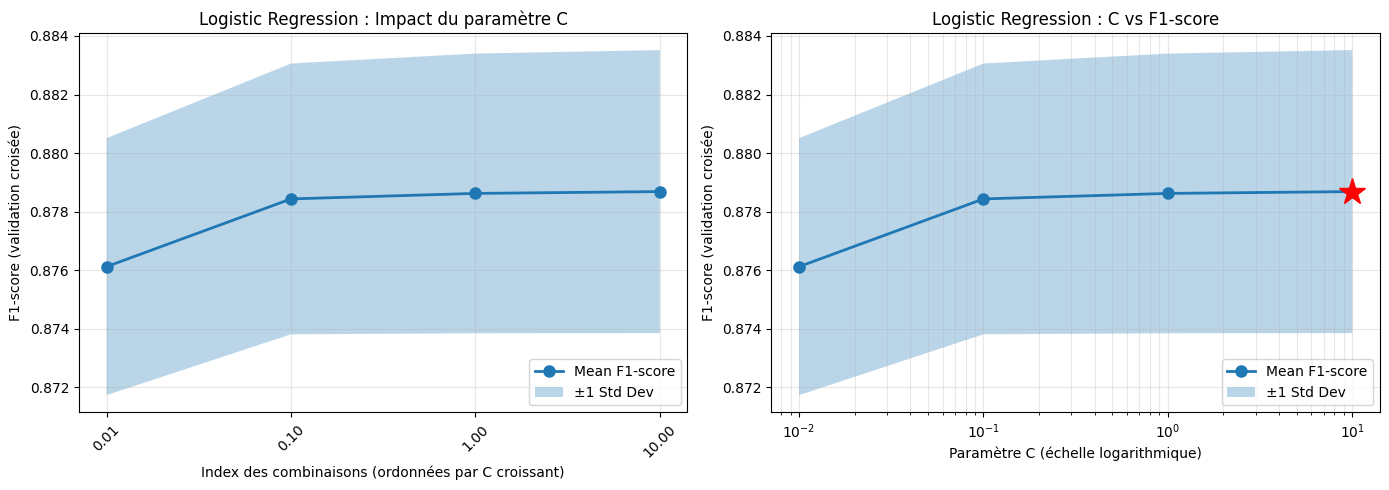


📈 Observations :
  • Meilleur C : 10.0
  • Meilleur F1-score : 0.8787
  • Écart-type : 0.0048

💡 Interprétation :
  • C est la force de régularisation L2 (inverse)
  • C faible = plus de régularisation = modèle plus simple
  • C élevé = moins de régularisation = modèle plus complexe


In [ ]:
## 2. Analyse détaillée de l'impact des hyperparamètres pour Logistic Regression

print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE : LOGISTIC REGRESSION")
print("="*80)

# Extraire les résultats de la grille
cv_results_lr = pd.DataFrame(gs.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_lr)}")
print(f"\nColonnes principales :")
cols_to_show = [col for col in cv_results_lr.columns if 'param_' in col or 'mean_test' in col]
print(cv_results_lr[cols_to_show].to_string())

# Visualiser l'impact du paramètre C
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1 : Score en fonction de C
ax1 = axes[0]
c_values = cv_results_lr['param_clf__C'].values
mean_test_scores = cv_results_lr['mean_test_score'].values
std_test_scores = cv_results_lr['std_test_score'].values

ax1.plot(range(len(c_values)), mean_test_scores, 'o-', linewidth=2, markersize=8, label='Mean F1-score')
ax1.fill_between(range(len(c_values)), 
                  mean_test_scores - std_test_scores,
                  mean_test_scores + std_test_scores,
                  alpha=0.3, label='±1 Std Dev')
ax1.set_xlabel('Index des combinaisons (ordonnées par C croissant)')
ax1.set_ylabel('F1-score (validation croisée)')
ax1.set_title('Logistic Regression : Impact du paramètre C')
ax1.set_xticks(range(len(c_values)))
ax1.set_xticklabels([f'{c:.2f}' for c in c_values], rotation=45)
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2 : Courbe de performance en fonction de C (log scale)
ax2 = axes[1]
ax2.semilogx(c_values, mean_test_scores, 'o-', linewidth=2, markersize=8, label='Mean F1-score')
ax2.fill_between(c_values, 
                  mean_test_scores - std_test_scores,
                  mean_test_scores + std_test_scores,
                  alpha=0.3, label='±1 Std Dev')
ax2.set_xlabel('Paramètre C (échelle logarithmique)')
ax2.set_ylabel('F1-score (validation croisée)')
ax2.set_title('Logistic Regression : C vs F1-score')
ax2.grid(alpha=0.3, which='both')
ax2.legend()

# Marquer le meilleur point
best_idx = cv_results_lr['rank_test_score'].argmin()
ax2.plot(cv_results_lr.loc[best_idx, 'param_clf__C'], 
         cv_results_lr.loc[best_idx, 'mean_test_score'],
         'r*', markersize=20, label='Meilleur')

plt.tight_layout()
plt.show()

print(f"\n📈 Observations :")
print(f"  • Meilleur C : {cv_results_lr.loc[best_idx, 'param_clf__C']}")
print(f"  • Meilleur F1-score : {cv_results_lr.loc[best_idx, 'mean_test_score']:.4f}")
print(f"  • Écart-type : {cv_results_lr.loc[best_idx, 'std_test_score']:.4f}")
print(f"\n💡 Interprétation :")
print(f"  • C est la force de régularisation L2 (inverse)")
print(f"  • C faible = plus de régularisation = modèle plus simple")
print(f"  • C élevé = moins de régularisation = modèle plus complexe")


ANALYSE DÉTAILLÉE : RANDOM FOREST

Nombre de combinaisons testées : 12

📊 Résultats de la validation croisée :
   param_clf__max_depth  param_clf__min_samples_split  param_clf__n_estimators  mean_test_score
0                    10                             2                      100         0.897643
1                    10                             2                      200         0.896939
2                    10                             5                      100         0.896645
3                    10                             5                      200         0.895930
4                    20                             2                      100         0.900666
5                    20                             2                      200         0.901750
6                    20                             5                      100         0.900531
7                    20                             5                      200         0.901972
8                  None 

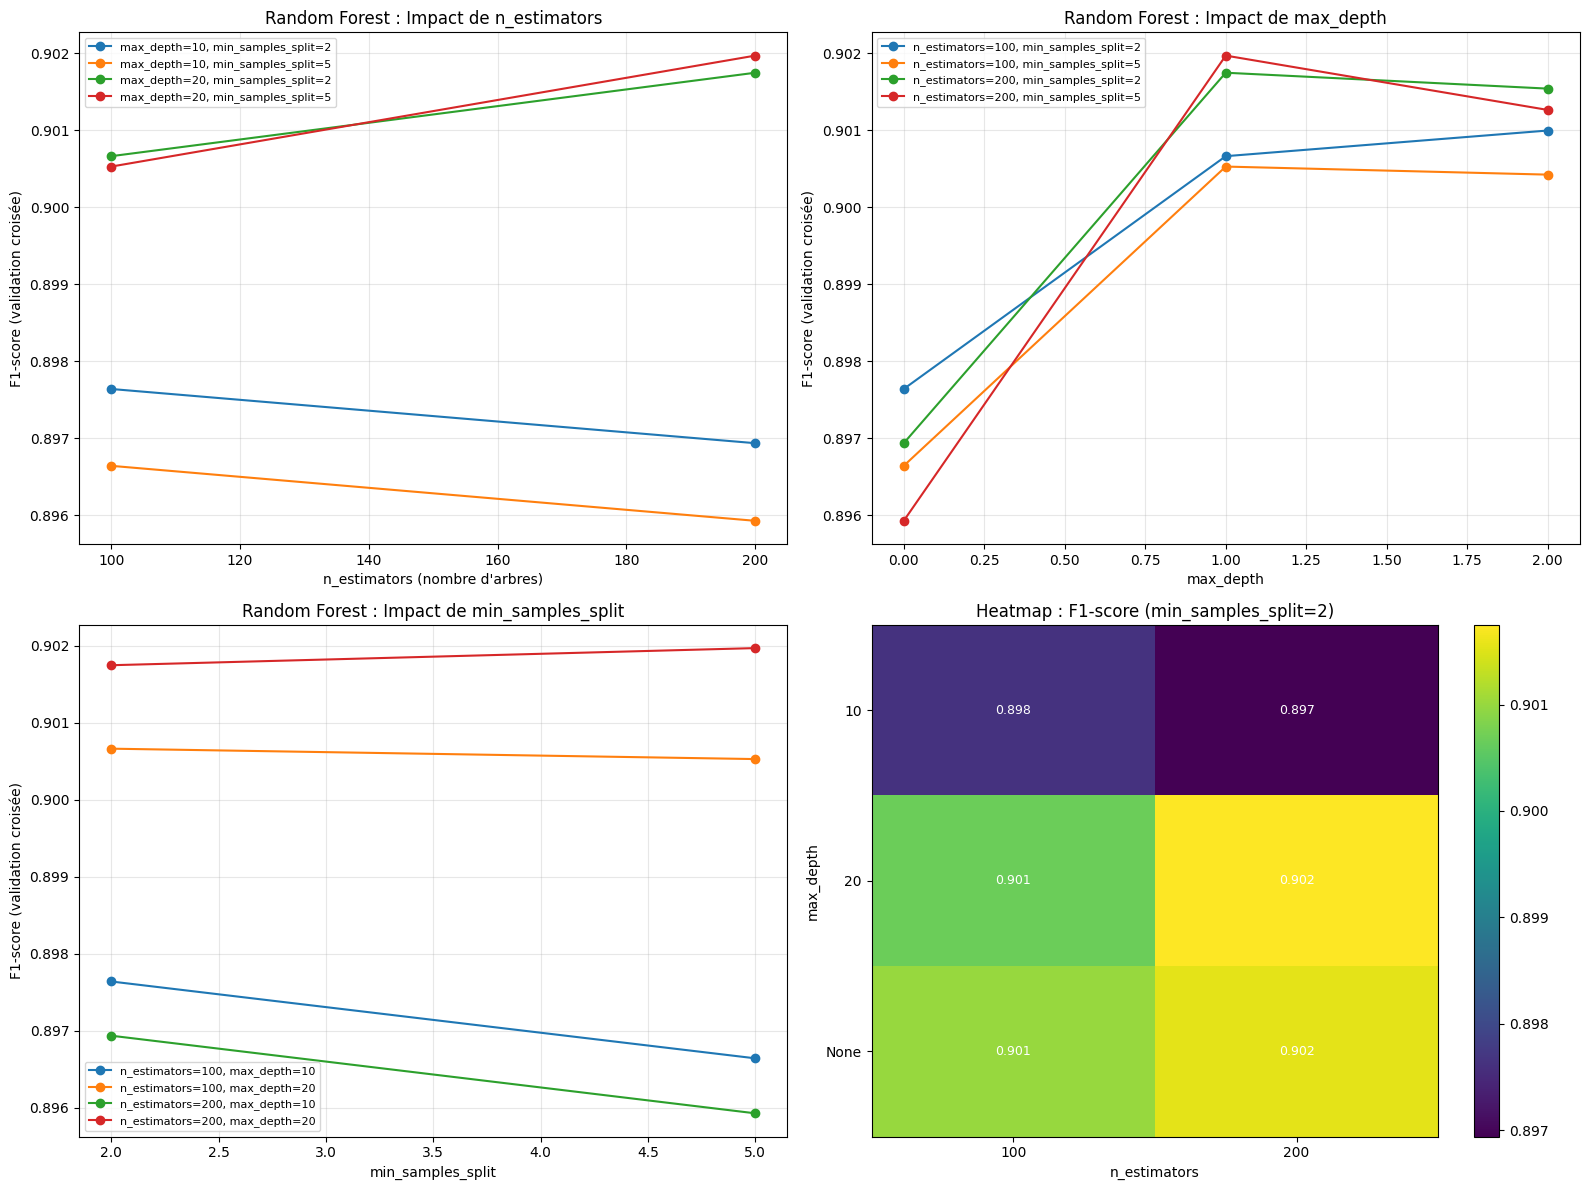


📈 Meilleure configuration :
  • n_estimators : 200
  • max_depth : 20
  • min_samples_split : 5
  • F1-score : 0.9020

💡 Interprétations :
  • n_estimators : plus d'arbres = généralement meilleur, mais plus lent
  • max_depth : contrôle la profondeur (deep trees = overfitting)
  • min_samples_split : feuille plus petite = plus détaillé (risque d'overfitting)


In [ ]:
## 3. Analyse détaillée de l'impact des hyperparamètres pour Random Forest

print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE : RANDOM FOREST")
print("="*80)

# Extraire les résultats de la grille
cv_results_rf = pd.DataFrame(gs_rf.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_rf)}")

# Afficher le tableau complet des résultats
cols_to_show = [col for col in cv_results_rf.columns if 'param_' in col or 'mean_test' in col]
print("\n📊 Résultats de la validation croisée :")
print(cv_results_rf[cols_to_show].to_string())

# Analyser l'impact de chaque hyperparamètre séparément
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gérer les valeurs None en les séparant
max_depths = sorted([x for x in cv_results_rf['param_clf__max_depth'].unique() if x is not None]) + [None]
min_splits = sorted(cv_results_rf['param_clf__min_samples_split'].unique())
n_ests = sorted(cv_results_rf['param_clf__n_estimators'].unique())

# 1. Impact de n_estimators
ax1 = axes[0, 0]
for max_depth in max_depths:
    for min_samples_split in min_splits:
        mask = (cv_results_rf['param_clf__max_depth'] == max_depth) & \
               (cv_results_rf['param_clf__min_samples_split'] == min_samples_split)
        data = cv_results_rf[mask].sort_values('param_clf__n_estimators')
        if len(data) > 0:
            label = f'max_depth={max_depth}, min_samples_split={min_samples_split}'
            ax1.plot(data['param_clf__n_estimators'], data['mean_test_score'], 'o-', label=label)

ax1.set_xlabel('n_estimators (nombre d\'arbres)')
ax1.set_ylabel('F1-score (validation croisée)')
ax1.set_title('Random Forest : Impact de n_estimators')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. Impact de max_depth
ax2 = axes[0, 1]
for n_est in n_ests:
    for min_samples_split in min_splits:
        mask = (cv_results_rf['param_clf__n_estimators'] == n_est) & \
               (cv_results_rf['param_clf__min_samples_split'] == min_samples_split)
        data = cv_results_rf[mask].copy()
        if len(data) > 0:
            # Trier avec None à la fin
            data['max_depth_sort'] = data['param_clf__max_depth'].apply(lambda x: float('inf') if x is None else x)
            data = data.sort_values('max_depth_sort')
            label = f'n_estimators={n_est}, min_samples_split={min_samples_split}'
            max_d_vals = [str(d) if d is not None else 'None' for d in data['param_clf__max_depth']]
            ax2.plot(range(len(max_d_vals)), data['mean_test_score'].values, 'o-', label=label)

ax2.set_xlabel('max_depth')
ax2.set_ylabel('F1-score (validation croisée)')
ax2.set_title('Random Forest : Impact de max_depth')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# 3. Impact de min_samples_split
ax3 = axes[1, 0]
for n_est in n_ests:
    for max_depth in max_depths:
        mask = (cv_results_rf['param_clf__n_estimators'] == n_est) & \
               (cv_results_rf['param_clf__max_depth'] == max_depth)
        data = cv_results_rf[mask].sort_values('param_clf__min_samples_split')
        if len(data) > 0:
            label = f'n_estimators={n_est}, max_depth={max_depth}'
            ax3.plot(data['param_clf__min_samples_split'], data['mean_test_score'], 'o-', label=label)

ax3.set_xlabel('min_samples_split')
ax3.set_ylabel('F1-score (validation croisée)')
ax3.set_title('Random Forest : Impact de min_samples_split')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

# 4. Heatmap de performance (n_estimators vs max_depth, pour min_samples_split=2)
ax4 = axes[1, 1]
mask_subset = cv_results_rf['param_clf__min_samples_split'] == 2
subset_data = cv_results_rf[mask_subset].copy()
if len(subset_data) > 0:
    # Convertir None en string pour la création du pivot_table
    subset_data['max_depth_label'] = subset_data['param_clf__max_depth'].apply(lambda x: 'None' if x is None else str(int(x)))
    subset_pivot = subset_data.pivot_table(
        values='mean_test_score',
        index='max_depth_label',
        columns='param_clf__n_estimators'
    )
    im = ax4.imshow(subset_pivot.values, cmap='viridis', aspect='auto')
    ax4.set_xticks(range(len(subset_pivot.columns)))
    ax4.set_yticks(range(len(subset_pivot.index)))
    ax4.set_xticklabels(subset_pivot.columns)
    ax4.set_yticklabels(subset_pivot.index)
    ax4.set_xlabel('n_estimators')
    ax4.set_ylabel('max_depth')
    ax4.set_title('Heatmap : F1-score (min_samples_split=2)')
    for i in range(len(subset_pivot.index)):
        for j in range(len(subset_pivot.columns)):
            val = subset_pivot.values[i, j]
            if not np.isnan(val):
                text = ax4.text(j, i, f'{val:.3f}',
                               ha="center", va="center", color="w", fontsize=9)
    plt.colorbar(im, ax=ax4)
else:
    ax4.text(0.5, 0.5, 'Pas de données pour cette combinaison', ha='center', va='center')

plt.tight_layout()
plt.show()

# Meilleur modèle
best_idx_rf = cv_results_rf['rank_test_score'].argmin()
print(f"\n📈 Meilleure configuration :")
print(f"  • n_estimators : {cv_results_rf.loc[best_idx_rf, 'param_clf__n_estimators']}")
print(f"  • max_depth : {cv_results_rf.loc[best_idx_rf, 'param_clf__max_depth']}")
print(f"  • min_samples_split : {cv_results_rf.loc[best_idx_rf, 'param_clf__min_samples_split']}")
print(f"  • F1-score : {cv_results_rf.loc[best_idx_rf, 'mean_test_score']:.4f}")
print(f"\n💡 Interprétations :")
print(f"  • n_estimators : plus d'arbres = généralement meilleur, mais plus lent")
print(f"  • max_depth : contrôle la profondeur (deep trees = overfitting)")
print(f"  • min_samples_split : feuille plus petite = plus détaillé (risque d'overfitting)")


ANALYSE DÉTAILLÉE : XGBOOST

Nombre de combinaisons testées : 36

📊 Résultats de la validation croisée :
    param_clf__learning_rate  param_clf__max_depth  param_clf__n_estimators  param_clf__subsample  mean_test_score
27                       0.3                     3                      200                   1.0         0.908954
18                       0.1                     5                      200                   0.8         0.908242
23                       0.1                     7                      200                   1.0         0.908118
20                       0.1                     7                      100                   0.8         0.907417
22                       0.1                     7                      200                   0.8         0.907384
33                       0.3                     7                      100                   1.0         0.907042
19                       0.1                     5                      200              

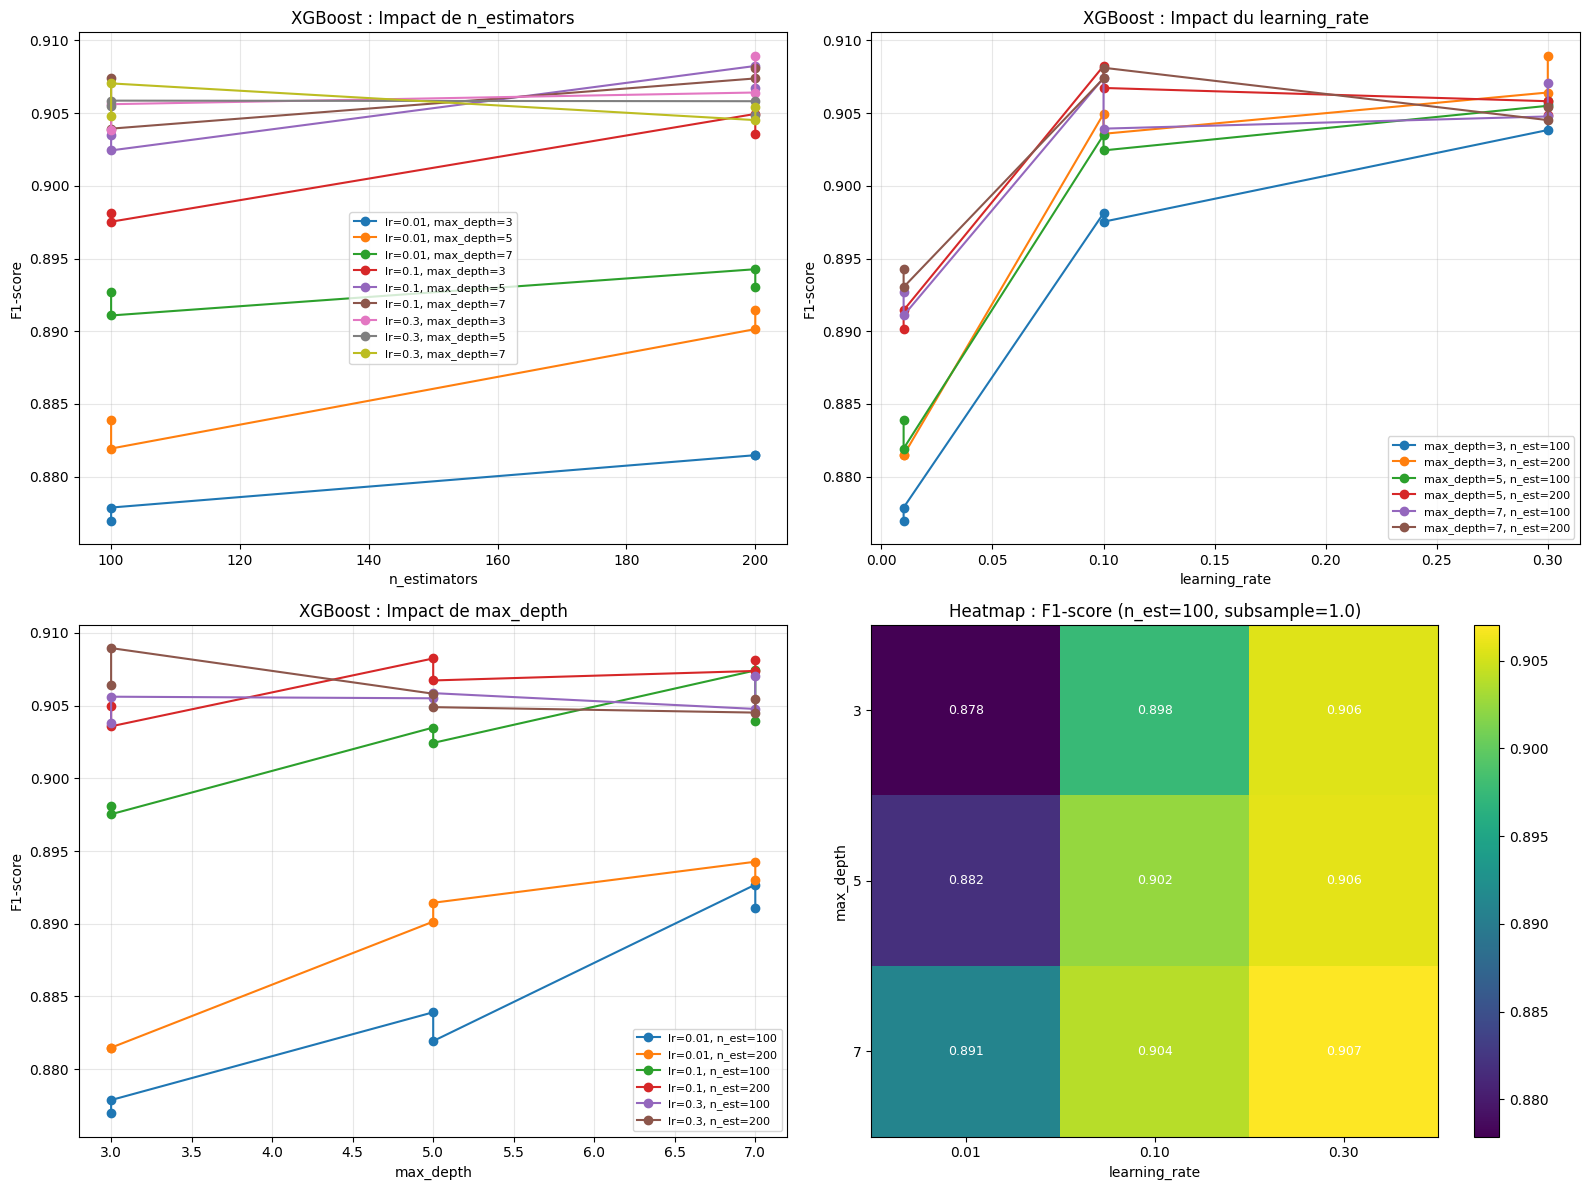


📈 Meilleure configuration :
  • n_estimators : 200
  • max_depth : 3
  • learning_rate : 0.3
  • subsample : 1.0
  • F1-score : 0.9090

💡 Interprétations :
  • learning_rate : vitesse d'apprentissage (petit = lent mais stable)
  • max_depth : profondeur des arbres (deep = complexe, risque d'overfitting)
  • subsample : fraction d'échantillons utilisés par arbre (< 1.0 = régularisation)


In [ ]:
## 4. Analyse détaillée de l'impact des hyperparamètres pour XGBoost

print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE : XGBOOST")
print("="*80)

# Extraire les résultats
cv_results_xgb = pd.DataFrame(gs_xgb.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_xgb)}")

# Tableau des résultats
cols_to_show = [col for col in cv_results_xgb.columns if 'param_' in col or 'mean_test' in col]
print("\n📊 Résultats de la validation croisée :")
print(cv_results_xgb[cols_to_show].sort_values('mean_test_score', ascending=False).head(10).to_string())

# Visualisations pour XGBoost
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Récupérer les valeurs uniques triées
learning_rates = sorted(cv_results_xgb['param_clf__learning_rate'].unique())
max_depths_xgb = sorted(cv_results_xgb['param_clf__max_depth'].unique())
n_ests_xgb = sorted(cv_results_xgb['param_clf__n_estimators'].unique())
subsamples = sorted(cv_results_xgb['param_clf__subsample'].unique())

# 1. Impact de n_estimators
ax1 = axes[0, 0]
for learning_rate in learning_rates:
    for max_depth in max_depths_xgb:
        mask = (cv_results_xgb['param_clf__learning_rate'] == learning_rate) & \
               (cv_results_xgb['param_clf__max_depth'] == max_depth)
        data = cv_results_xgb[mask].sort_values('param_clf__n_estimators')
        if len(data) > 0:
            label = f'lr={learning_rate}, max_depth={max_depth}'
            ax1.plot(data['param_clf__n_estimators'], data['mean_test_score'], 'o-', label=label)

ax1.set_xlabel('n_estimators')
ax1.set_ylabel('F1-score')
ax1.set_title('XGBoost : Impact de n_estimators')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. Impact de learning_rate
ax2 = axes[0, 1]
for max_depth in max_depths_xgb:
    for n_est in n_ests_xgb:
        mask = (cv_results_xgb['param_clf__max_depth'] == max_depth) & \
               (cv_results_xgb['param_clf__n_estimators'] == n_est)
        data = cv_results_xgb[mask].sort_values('param_clf__learning_rate')
        if len(data) > 0:
            label = f'max_depth={max_depth}, n_est={n_est}'
            ax2.plot(data['param_clf__learning_rate'], data['mean_test_score'], 'o-', label=label)

ax2.set_xlabel('learning_rate')
ax2.set_ylabel('F1-score')
ax2.set_title('XGBoost : Impact du learning_rate')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# 3. Impact de max_depth
ax3 = axes[1, 0]
for learning_rate in learning_rates:
    for n_est in n_ests_xgb:
        mask = (cv_results_xgb['param_clf__learning_rate'] == learning_rate) & \
               (cv_results_xgb['param_clf__n_estimators'] == n_est)
        data = cv_results_xgb[mask].sort_values('param_clf__max_depth')
        if len(data) > 0:
            label = f'lr={learning_rate}, n_est={n_est}'
            ax3.plot(data['param_clf__max_depth'], data['mean_test_score'], 'o-', label=label)

ax3.set_xlabel('max_depth')
ax3.set_ylabel('F1-score')
ax3.set_title('XGBoost : Impact de max_depth')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

# 4. Heatmap learning_rate vs max_depth (n_estimators=100, subsample=1.0)
ax4 = axes[1, 1]
mask_subset = (cv_results_xgb['param_clf__n_estimators'] == 100) & \
              (cv_results_xgb['param_clf__subsample'] == 1.0)
subset_data = cv_results_xgb[mask_subset].copy()
if len(subset_data) > 0:
    # Convertir learning_rate et max_depth pour pivot
    subset_data['learning_rate_label'] = subset_data['param_clf__learning_rate'].astype(str)
    subset_data['max_depth_label'] = subset_data['param_clf__max_depth'].astype(str)
    subset_pivot = subset_data.pivot_table(
        values='mean_test_score',
        index='max_depth_label',
        columns='learning_rate_label'
    )
    if subset_pivot.notna().sum().sum() > 0:
        im = ax4.imshow(subset_pivot.values, cmap='viridis', aspect='auto')
        ax4.set_xticks(range(len(subset_pivot.columns)))
        ax4.set_yticks(range(len(subset_pivot.index)))
        ax4.set_xticklabels([f'{x:.2f}' for x in [float(col) for col in subset_pivot.columns]])
        ax4.set_yticklabels(subset_pivot.index)
        ax4.set_xlabel('learning_rate')
        ax4.set_ylabel('max_depth')
        ax4.set_title('Heatmap : F1-score (n_est=100, subsample=1.0)')
        for i in range(len(subset_pivot.index)):
            for j in range(len(subset_pivot.columns)):
                val = subset_pivot.values[i, j]
                if not np.isnan(val):
                    text = ax4.text(j, i, f'{val:.3f}',
                                   ha="center", va="center", color="w", fontsize=9)
        plt.colorbar(im, ax=ax4)
    else:
        ax4.text(0.5, 0.5, 'Pas assez de données', ha='center', va='center')
else:
    ax4.text(0.5, 0.5, 'Pas de données pour cette combinaison', ha='center', va='center')

plt.tight_layout()
plt.show()

best_idx_xgb = cv_results_xgb['mean_test_score'].idxmax()
print(f"\n📈 Meilleure configuration :")
print(f"  • n_estimators : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__n_estimators']}")
print(f"  • max_depth : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__max_depth']}")
print(f"  • learning_rate : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__learning_rate']}")
print(f"  • subsample : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__subsample']}")
print(f"  • F1-score : {cv_results_xgb.loc[best_idx_xgb, 'mean_test_score']:.4f}")
print(f"\n💡 Interprétations :")
print(f"  • learning_rate : vitesse d'apprentissage (petit = lent mais stable)")
print(f"  • max_depth : profondeur des arbres (deep = complexe, risque d'overfitting)")
print(f"  • subsample : fraction d'échantillons utilisés par arbre (< 1.0 = régularisation)")


COMPARAISON GLOBALE DES MODÈLES

📊 TABLEAU DE COMPARAISON
             Modèle  Accuracy  Precision  Recall  F1-score  ROC-AUC  CV F1-score  N° hyperparamètres
Logistic Regression   0.87300   0.847300  0.9100  0.877531 0.952638     0.878688                   1
      Random Forest   0.89925   0.880057  0.9245  0.901731 0.972346     0.901972                   3
           LightGBM   0.90675   0.898970  0.9165  0.907650 0.975355     0.909239                   4
            XGBoost   0.90600   0.894558  0.9205  0.907344 0.974710     0.908954                   4

📊 TABLEAU DE COMPARAISON
             Modèle  Accuracy  Precision  Recall  F1-score  ROC-AUC  CV F1-score  N° hyperparamètres
Logistic Regression   0.87300   0.847300  0.9100  0.877531 0.952638     0.878688                   1
      Random Forest   0.89925   0.880057  0.9245  0.901731 0.972346     0.901972                   3
           LightGBM   0.90675   0.898970  0.9165  0.907650 0.975355     0.909239                   4
      

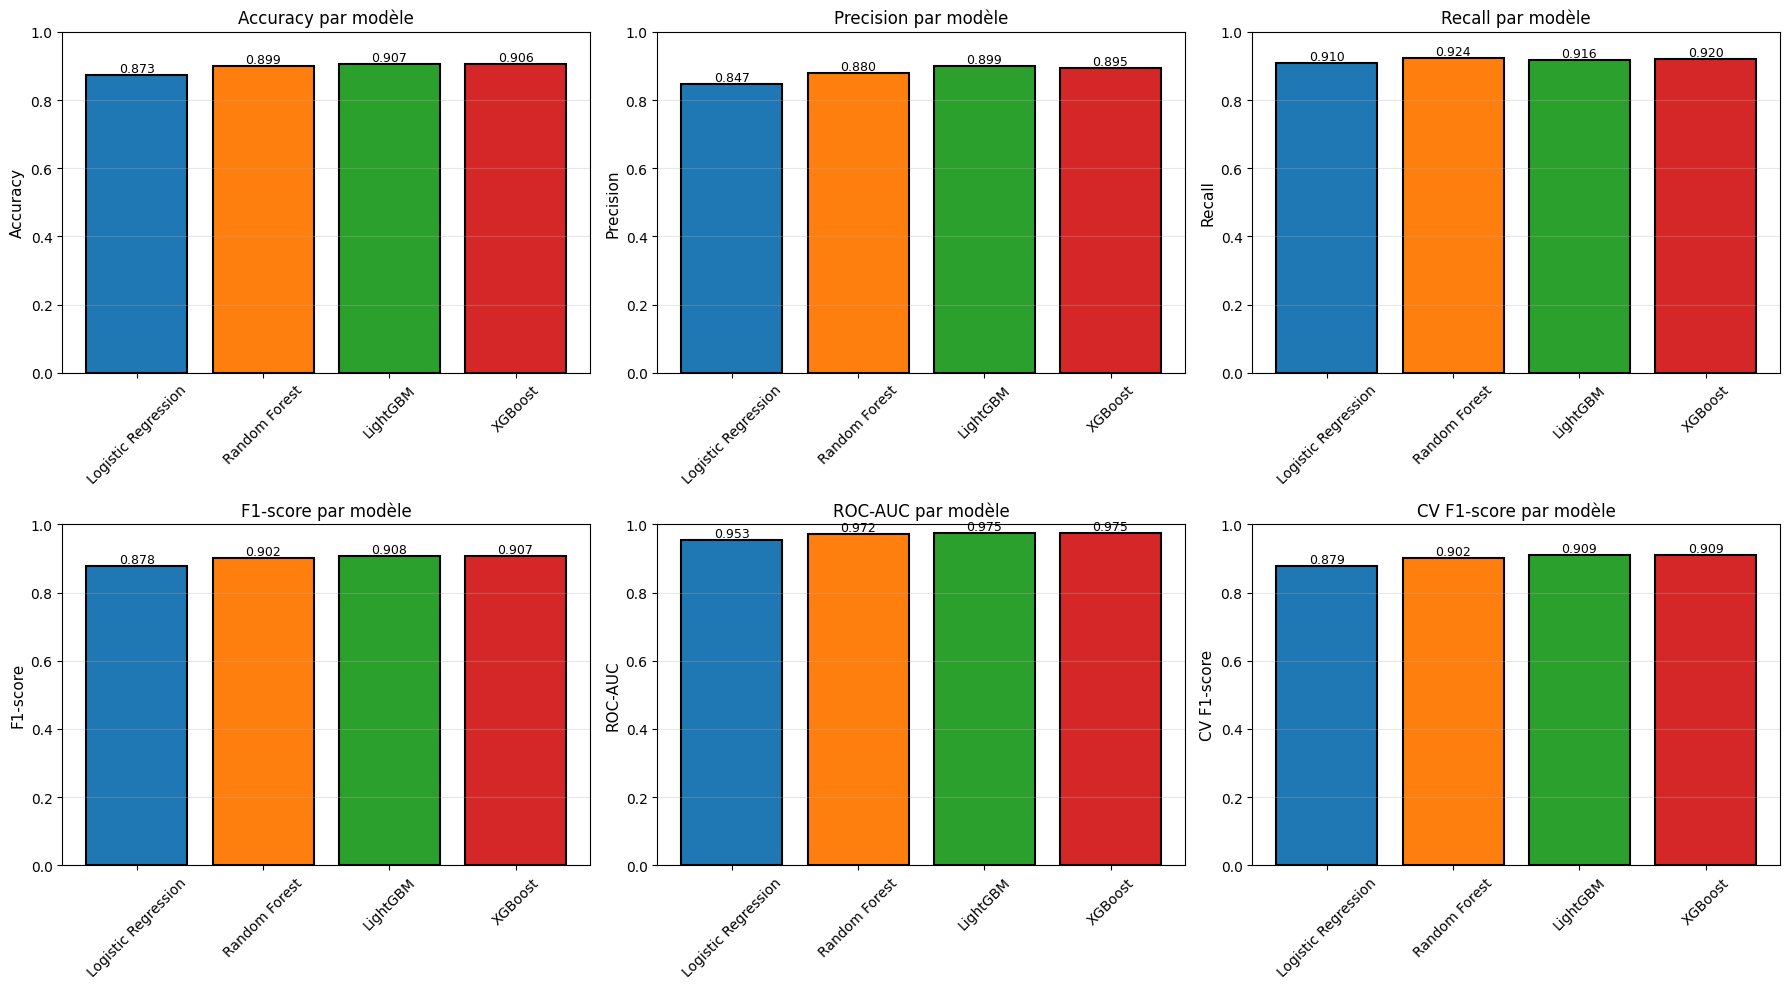


🏆 CLASSEMENT DES MODÈLES (par F1-score)
🥇 1. LightGBM             - F1-score: 0.9077 (CV: 0.9092)
🥈 2. XGBoost              - F1-score: 0.9073 (CV: 0.9090)
🥉 3. Random Forest        - F1-score: 0.9017 (CV: 0.9020)
4️⃣ 4. Logistic Regression  - F1-score: 0.8775 (CV: 0.8787)

📌 OBSERVATIONS CLÉS

✅ Meilleur modèle : LightGBM
   • F1-score test : 0.9077
   • F1-score CV : 0.9092
   • Différence : 0.0016

❌ Modèle avec le moins bon F1 : Logistic Regression
   • F1-score test : 0.8775

📊 Statistiques des F1-scores :
   • Moyenne : 0.8986
   • Écart-type : 0.0124
   • Min/Max : 0.8775 / 0.9077


In [ ]:
## 5. Comparaison globale des modèles et de leurs hyperparamètres

print("\n" + "="*80)
print("COMPARAISON GLOBALE DES MODÈLES")
print("="*80)

# Créer un résumé de comparaison
comparison_data = []

# Logistic Regression
y_pred_lr = best.predict(X_test)
y_proba_lr = best.predict_proba(X_test)[:, 1]
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
comparison_data.append({
    'Modèle': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr),
    'CV F1-score': gs.best_score_,
    'N° hyperparamètres': len(gs.best_params_)
})

# Random Forest
y_pred_rf_eval = best_rf.predict(X_test)
y_proba_rf_eval = best_rf.predict_proba(X_test)[:, 1]
comparison_data.append({
    'Modèle': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf_eval),
    'Precision': precision_score(y_test, y_pred_rf_eval),
    'Recall': recall_score(y_test, y_pred_rf_eval),
    'F1-score': f1_score(y_test, y_pred_rf_eval),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf_eval),
    'CV F1-score': gs_rf.best_score_,
    'N° hyperparamètres': len(gs_rf.best_params_)
})

# LightGBM
y_pred_lgbm_eval = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
comparison_data.append({
    'Modèle': 'LightGBM',
    'Accuracy': accuracy_score(y_test, y_pred_lgbm_eval),
    'Precision': precision_score(y_test, y_pred_lgbm_eval),
    'Recall': recall_score(y_test, y_pred_lgbm_eval),
    'F1-score': f1_score(y_test, y_pred_lgbm_eval),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lgbm),
    'CV F1-score': gs_lgbm.best_score_,
    'N° hyperparamètres': len(gs_lgbm.best_params_)
})

# XGBoost
y_pred_xgb_eval = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
comparison_data.append({
    'Modèle': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb_eval),
    'Precision': precision_score(y_test, y_pred_xgb_eval),
    'Recall': recall_score(y_test, y_pred_xgb_eval),
    'F1-score': f1_score(y_test, y_pred_xgb_eval),
    'ROC-AUC': roc_auc_score(y_test, y_proba_xgb),
    'CV F1-score': gs_xgb.best_score_,
    'N° hyperparamètres': len(gs_xgb.best_params_)
})

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 TABLEAU DE COMPARAISON")
print(comparison_df.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'CV F1-score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    models = comparison_df['Modèle'].values
    
    bars = ax.bar(models, values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} par modèle', fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Rotation des labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Classement des modèles par F1-score
print("\n" + "="*80)
print("🏆 CLASSEMENT DES MODÈLES (par F1-score)")
print("="*80)
ranking = comparison_df.sort_values('F1-score', ascending=False).reset_index(drop=True)
for idx, (_, row) in enumerate(ranking.iterrows()):
    medal = ['🥇', '🥈', '🥉', '4️⃣'][idx]
    print(f"{medal} {idx+1}. {row['Modèle']:20} - F1-score: {row['F1-score']:.4f} (CV: {row['CV F1-score']:.4f})")

print("\n" + "="*80)
print("📌 OBSERVATIONS CLÉS")
print("="*80)
best_model = ranking.iloc[0]
worst_model = ranking.iloc[-1]

print(f"\n✅ Meilleur modèle : {best_model['Modèle']}")
print(f"   • F1-score test : {best_model['F1-score']:.4f}")
print(f"   • F1-score CV : {best_model['CV F1-score']:.4f}")
print(f"   • Différence : {abs(best_model['F1-score'] - best_model['CV F1-score']):.4f}")

print(f"\n❌ Modèle avec le moins bon F1 : {worst_model['Modèle']}")
print(f"   • F1-score test : {worst_model['F1-score']:.4f}")

# Écart-type de la performance
f1_scores = comparison_df['F1-score'].values
print(f"\n📊 Statistiques des F1-scores :")
print(f"   • Moyenne : {f1_scores.mean():.4f}")
print(f"   • Écart-type : {f1_scores.std():.4f}")
print(f"   • Min/Max : {f1_scores.min():.4f} / {f1_scores.max():.4f}")